# Selección de cripto activos para una cartera de inversión

In [ ]:
##Ejecutar la Primera Vez para actualizar la lib de sklearn, para evitar error en train test split

#!pip install auto_ts --upgrade

# Trabajo Práctico 3 - Introducción al Aprendizaje Automático

# Introducción

En este práctico aplicaremos algunas técnicas de aprendizaje automático para predecir precios de activos, a partir de los features que hemos trabajado en el práctico anterior. Exploraremos modelos simples de regresión y clasificación. Para validar los modelos procedemos a evaluar su bondad de ajuste, es decir, que "tan bueno" es el poder predictivo del modelo y comparar su desempeño.

**Conjunto de Entrenamiento y Test**

Para entrenar modelos de ML y seleccionar el más adecuado, debemos particionar los datos en conjuntos de entrenamiento y test (o entrenamiento, validación y test). Si bien la práctica más habitual es seleccionar estos conjuntos al azar, esta metodología no es conveniente cuando trabajamos con series de tiempo, ya que romper la estructura de los datos significa romper la autocorrelación, que es lo que da sentido al análisis. Frente a esto, una posibilidad es realizar la división de datos a partir del procedimiento [Walk-Forward Validation](https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/), otra es implementar lo que se conoce como [timeSeriesSplit](https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split).

¡Los invito a indagar sobre estas metodologías!

**Variables Predictoras**

Los predictores son datos que consideramos relevantes para el comportamiento del mercado. En nuestro caso, trabajaremos con los indicadores técnicos calculados en el trabajo práctico anterior, pero estos pueden ser muy diversos, como datos de sentimiento, datos de amplitud, datos básicos, gubernamentales, etc., que nos ayudarán a hacer nuestras predicciones. 


# ¡Actividades!

En este práctico evaluaremos el potencial de modelos predictivos simples sobre algunos activos. Esta será la base para construir una canasta de activos con riesgo controlado. 

**¡Para tener en cuenta!**

Es esencial el preprocesamiento de datos, parte de esta tarea fue realizada en el TP anterior. Sin embargo, nos tomaremos un tiempo para revisarlo.

- ¿Hay valores faltantes/perdidos en nuestro set de datos? ¿ya fueron tratados?

- Vimos que si la varianza de los features con los que trabajaremos difieren en magnitud, esto podría entorpecer nuestro trabajo, ¿qué hicimos al respecto?

**¡¡¡Importante!!!**

El valor de algunos indicadores tal cual los hemos calculado no nos sirve, sino que debemos trabajar con las señales que ellos nos brindan. Es el caso de MACD y las medias móviles. Por ello, podemos trabajar con las siguientes columnas:

```
df['ClgtS10'] = np.where(df['Close'] > df['S10'], 1, -1)
df['S10gtS30'] = np.where(df['S10'] > df['S30'], 1, -1)
df['MACDSIGgtMACD'] = np.where(df['MACDsignal'] > df['MACD'], 1, -1)
```
Esto es porque, por ejemplo, es valor de una media móvil de 10 periodos, nada nos dice sobre la condición del mercado. Sin embargo, si comparamos el valor del precio del activo con el valor de la media móvil, el primero se encuentra por encima del segundo, esto indica que el activo está recuperando su valor. 

Estos ejemplos son a modo ilustrativo y dependerá de los indicadores con lo que hayan decidido trabajar. 

## Parte I

* En esta etapa nuestro objetivo es implementar un modelo de regresión lineal sobre algún activo para predecir su tasa de cambio (ya sea respecto al precio open o close). Para comenzar nuestra tarea, es suficiente elegir 2 o 3 activos y considerar los features calculados anteriormente (sientanse libres de agregar cualquier otra característica que les parezca interesante)

* Evalúen los resultados, con algunas métricas útiles para problemas de regresión, tales como Error Cuadrático Medio (RMSE), el Error Absoluto Medio (MAE) y Error Absoluto Mediano (MedAE).

* Grafiquen la serie de precios y los resultados de su predicción. ¿Qué pueden decir?


## Parte II 

* Creen un árbol de decisión de regresión (usando la función DecisionTreeRegressor de sklearn) para predecir el rendimiento específico del activo en la sesión siguiente, el árbol de decisiones debería ayudarnos a elegir la mejor combinación de indicadores y sus parámetros para maximizar el resultado esperado. Exploren diferentes valores para los parámetros del algoritmo (criterion, max_depth, min_samples_leaf).

* Visualicen alguno de los árboles. 


## Parte III - Opcional
 
- Repitan algunos de los experimentos utilizando diferentes temporalidades (1 hora, 1 día, 1 semana). 
- Apliquen árboles de clasificación para decidir si un activo mantendrá su precio, subirá o disminuirá. Observación: Pueden utlizar las mismas variables predictoras que en el caso de árboles de regresión, solo deben modificar la variable target. 

**¡Recuerden!** 

Nunca Modificar los Datos Crudos u Originales Al finalizar la limpieza, deberán guardar el dataset resultante, para asegurarse de no modificar los datos originales.

# Fecha de entrega

- __Versión preliminar: 15/8__ 

- __Versión final: 22/8__

# Condiciones de entrega

Realizar un informe en el cual se presenten los resultados y conclusiones del análisis desarrollado. El mismo debe estar pensado para un público técnico pero que desconoce los aspectos propios del problema a resolver. Dicho informe puede ser un notebook, a condición de que en el mismo se efectúe un análisis escrito suficientemente detallado de los resultados. 

# **Resolución**

## **Intro**

importaciones iniciales, carga del dataset y creación del DataFrame

#### **Importaciones**

In [ ]:
import pandas as pd
import numpy as np


from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline


from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error  
from sklearn.metrics import median_absolute_error


from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Instalación e importación de TALIB
#Hay que correrlo cada vez que se reinicia el entorno de ejecucion
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h516909a_0.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py37ha21ca33_2.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.7/dist-packages/ lib/python3.7/site-packages/talib --strip-components=3


import talib

In [ ]:
def ADX(data: pd.DataFrame, period: int):
    df_aux = data.copy()
    alpha = 1/period

    # TR (True Range), calculo del rango verdadero
    df_aux['H-L'] = df_aux['high'].shift(1) - df_aux['low'].shift(1)
    df_aux['H-C'] = np.abs(df_aux['high'].shift(1) - df_aux['close'].shift(2))
    df_aux['L-C'] = np.abs(df_aux['low'].shift(1) - df_aux['close'].shift(2))
    df_aux['TR'] = df_aux[['H-L', 'H-C', 'L-C']].max(axis=1)
    del df_aux['H-L'], df_aux['H-C'], df_aux['L-C']

    # ATR (Average True Range), promedio ponderado del TR
    df_aux['ATR'] = df_aux['TR'].ewm(alpha=alpha, adjust=False).mean()

    # +-DX (Indicador direccional)
    df_aux['H-pH'] = df_aux['high'].shift(1) - df_aux['high'].shift(2)
    df_aux['pL-L'] = df_aux['low'].shift(2) - df_aux['low'].shift(1)
    df_aux['+DX'] = np.where(
        (df_aux['H-pH'] > df_aux['pL-L']) & (df_aux['H-pH']>0),
        df_aux['H-pH'],
        0.0
    )
    df_aux['-DX'] = np.where(
        (df_aux['H-pH'] < df_aux['pL-L']) & (df_aux['pL-L']>0),
        df_aux['pL-L'],
        0.0
    )
    del df_aux['H-pH'], df_aux['pL-L']

    # +- DMI (Indice de movimiento direccional_ Directional Movement Index)
    df_aux['S+DM'] = df_aux['+DX'].ewm(alpha=alpha, adjust=False).mean()
    df_aux['S-DM'] = df_aux['-DX'].ewm(alpha=alpha, adjust=False).mean()
    df_aux['+DMI'] = (df_aux['S+DM']/df_aux['ATR'])*100
    df_aux['-DMI'] = (df_aux['S-DM']/df_aux['ATR'])*100
    del df_aux['S+DM'], df_aux['S-DM']

    # ADX (Average Directional Movement Index)
    df_aux['DX'] = (np.abs(df_aux['+DMI'] - df_aux['-DMI'])/(df_aux['+DMI'] + df_aux['-DMI']))*100
    df_aux['ADX'] =df_aux['DX'].ewm(alpha=alpha, adjust=False).mean()
    del df_aux['DX'], df_aux['TR'], df_aux['-DX'], df_aux['+DX'], df_aux['+DMI'], df_aux['-DMI']

    return df_aux

#### **Carga de Data SET**
Notebook anterior 1ra Parte:
https://colab.research.google.com/drive/13NeIxm95j-13Kxqvrd8xgjgYp-NIY3co

Notebook anterior 2da Parte:
https://colab.research.google.com/drive/1CWHdhOfbbLNjQhXHQzBlBMXkIbTiyfYn#scrollTo=aHX9vFG_0OVu

Vamos a importar solo las monedas más antinuas que arrancan en el 2018 y son 5:
* 'NEOUSDT'
* 'LTCUSDT'
* 'ETHUSDT'
* 'BTCUSDT'
* 'BNBUSDT'

In [ ]:
####### PARA CARGAR DESDE GIT HUB ####
#df=pd.DataFrame()  
#Url del DATASET RAW   
#url='https://raw.githubusercontent.com/charly3d/Diplomatura-de-Datos-Mentoria/main/TP3_Intro_Aprendizaje_Automatico/df_old_coins_to_tp3.csv'   
                                                                                                                                        
#df_imp=pd.read_csv(url,index_col=0)

In [ ]:
###### PARA CARGAR DESDE DRIVE ####
url = 'https://drive.google.com/file/d/1-kGBNHoBdloaHq8OmHnuW79G1z4VtI6J/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
#print(path)
df_imp=pd.read_csv(path,sep=',', parse_dates=True,header=0,index_col=0)
df_imp.head(3)

,date,open,close,high,low,volume,rendimiento_simple,rendimiento_log,media_movil_3_periodos,media_movil_15_periodos,media_movil_60_periodos,RSI_100,RSI_14,RSI_6,MACD,signal,hist,ADX,ATR,Volatilidad_50_periodos,Std_U,Std_D,Corr_3_periodos,OD,OL,MFI,OBV
cripto_activo,,,,,,,,,,,,,,,,,,,,,,,,,,,
NEOUSDT,2018-01-01 00:00:00,74.854,72.565,75.072,71.050,4880.223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.960,6.370,NaN,NaN,NaN,NaN,NaN
NEOUSDT,2018-01-01 01:00:00,72.788,72.680,74.000,72.152,5158.767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.022000,NaN,0.218,3.804,NaN,-2.066,0.223,NaN,4880.223
NEOUSDT,2018-01-01 02:00:00,72.720,74.293,74.679,72.502,819.395,0.001585,0.001584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.866714,NaN,1.212,0.636,NaN,-0.068,0.040,NaN,10038.990


In [ ]:
#Lista de Monedas
coins=list(df_imp.index.unique())

In [ ]:
#Formato de Fecha

df_imp.date=pd.to_datetime(df_imp.date) 
df_imp=df_imp.reset_index()

# Multi Index
df_imp.set_index(['cripto_activo','date'],inplace=True)
df_imp.head(3)

open   close  ...  MFI        OBV
cripto_activo date                                 ...                
NEOUSDT       2018-01-01 00:00:00  74.854  72.565  ...  NaN        NaN
              2018-01-01 01:00:00  72.788  72.680  ...  NaN   4880.223
              2018-01-01 02:00:00  72.720  74.293  ...  NaN  10038.990

[3 rows x 26 columns]

In [ ]:
df_imp.sort_index(level=[0, 1], inplace=True)
df_imp.head(3)

open   close  ...  MFI       OBV
cripto_activo date                                 ...               
BNBUSDT       2018-01-01 00:00:00  8.5478  8.3559  ...  NaN       NaN
              2018-01-01 01:00:00  8.3558  8.2199  ...  NaN  49487.14
              2018-01-01 02:00:00  8.2200  8.2235  ...  NaN  24494.51

[3 rows x 26 columns]

In [ ]:
df=df_imp.copy()

In [ ]:
coins

['NEOUSDT', 'LTCUSDT', 'ETHUSDT', 'BTCUSDT', 'BNBUSDT']

#### **Agregar Precio de cierre, volumen de la sesion anterior y rendimiento Log Objetivo de predecir**


In [ ]:
for cripto in coins: 
  df.loc[cripto,'close_before']=df.loc[cripto,'close'].shift(1).values
  df.loc[cripto,'volume_before']=df.loc[cripto,'volume'].shift(1).values

  #Columna objetivo y, seria rendimiento logaritmico de la sesion actual  
  df.loc[cripto,'r_log_target']=np.log(df.loc[cripto,'close']/df.loc[cripto,'close'].shift(1)).values
  #el r log que traemos es de la ultima sesion y la penultima (pasado) y nuestro objetivo  es el rendimiento de la sesion actual o "futura"


Se cambian el nombre de algunas columnas, para hacerlos más cortos

In [ ]:
#cambio de nombre de columnas

nvo_nombres={'rendimiento_simple':'r_sim',
             'rendimiento_log':'r_log',
             'media_movil_3_periodos':'mean_m3',
             'media_movil_15_periodos':'mean_m15',
             'media_movil_60_periodos':'mean_m60',
             'Volatilidad_50_periodos':'vol_50',
             'Corr_3_periodos':'corr_3'
             }
             
df=df.rename(columns=nvo_nombres) 
np.random.seed(0) #Fijar Semilla Random

#### **Preprocesamiento**


##### **Datos nulos**

In [ ]:
df.isna().mean()*100     #Calculo de porcentaje de datos nulos para cada columna

open             0.000000
close            0.000000
high             0.000000
low              0.000000
volume           0.000000
r_sim            0.006766
r_log            0.006766
mean_m3          0.010149
mean_m15         0.050744
mean_m60         0.202977
RSI_100          0.341678
RSI_14           0.050744
RSI_6            0.023681
MACD             0.111637
signal           0.111637
hist             0.111637
ADX              0.007442
ATR              0.003383
vol_50           0.172530
Std_U            0.000000
Std_D            0.000000
corr_3           0.043978
OD               0.003383
OL               0.003383
MFI              0.050744
OBV              0.003383
close_before     0.003383
volume_before    0.003383
r_log_target     0.003383
dtype: float64

In [ ]:
print(round(max(df.isna().mean()*100),3),'%')     #Maximo porcentaje de nulos

0.342 %


Hay nulos en los indicadores calculados que requieren de muchos periodos para calcularse, por lo que en los primeros periodos no tienen valores. 
Igualmente no se supera el 0.35% de datos nulos, por lo que se podrian borrar

In [ ]:
df.dropna(inplace=True)         #Eliminacion de datos nulos
max(df.isna().mean()*100)       #Chequeo de maximo porcentaje de nulos

0.0

In [ ]:
df.loc['BTCUSDT'].head(3)

,open,close,high,low,volume,r_sim,r_log,mean_m3,mean_m15,mean_m60,RSI_100,RSI_14,RSI_6,MACD,signal,hist,ADX,ATR,vol_50,Std_U,Std_D,corr_3,OD,OL,MFI,OBV,close_before,volume_before,r_log_target
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-05 05:00:00,14820.05,15000.00,15038.75,14756.00,863.362834,-0.009710,-0.009758,14961.176667,14807.766000,14778.694908,54.471444,50.764335,44.416306,82.828044,60.691675,22.136370,17.585833,314.987154,0.012869,113.63,370.00,0.315401,-149.95,0.0,55.841558,2204.180918,14820.05,947.316775,0.012069
2018-01-05 06:00:00,14999.00,14952.34,15020.00,14700.00,779.698664,0.012142,0.012069,14928.473333,14840.228667,14799.028241,55.037559,55.602394,57.260255,81.123664,64.778073,16.345592,17.963691,312.684500,0.012857,218.70,64.05,0.346743,178.95,-1.0,64.108440,3067.543752,15000.00,863.362834,-0.003182
2018-01-05 07:00:00,14952.34,14920.14,14979.78,14822.32,844.120506,-0.003177,-0.003182,14924.130000,14880.184000,14805.233908,54.855083,54.086506,53.342746,76.295177,67.081493,9.213683,18.535645,313.207036,0.012722,21.00,299.00,0.136403,-46.66,0.0,56.800892,2287.845088,14952.34,779.698664,-0.002156


##### **Escalado o Estandarizacíon**

Si bien se realizó en el practico anterior, los datos que exportamos del trabajo anterior eran sin escalar, por lo que se debe llevar a cabo un **escalado o una estandarización** de los datos 

En nuestro caso tenemos una variable Volume y variables de precio con mucha diferencia de magnitud, con la variable volume que tiene outliers más importantes que el precio, pero las variables de precio de algunas monedas tienen rangos muy grandes a lo largo del tiempo, **lo mejor es realizar un *estandarizado* .**

La **estandarizacion** escala los datos y los desplaza para dejarlos con una **media de 0 y una varianza de 1**.

El escalado se va a realizar dentro de un pipeline

##### **Metodo de de las Componentes principales (PCA)**

De ser conveniente se va a realizar dentro de un pipeline

####**Crear nuevos atributos categoricos con indicadores calculados**

####**MFI**

El Money Flow Index oscila entre los niveles 0 y 100. Un uso básico del índice de flujo de dinero es indicar cuándo el mercado está sobrecomprado o sobrevendido.

Mercado en sobreventa: valores inferiores a 20

Mercado en sobrecompra: niveles superiores a 80

####**MACD**
Los cruces entre las líneas MACD y Señal darán señales alcistas o bajistas sobre el sentido de la evolución del precio en función de lo siguiente:

*   Cuando el cruce de la línea MACD con la línea Señal se produzca de abajo a arriba, la señal será alcista.
*   Cuando el cruce de la línea MACD con la línea Señal se produzca de arriba para abajo, la señal será bajista.

####**RSI**
los valores altos de RSI son una señal de mercado alcista (que puede estar sobrecomprado, dependiendo de la visión particular y estilo de negociación).

Por el contrario, un RSI bajo significa que el RS también está bajo y los movimientos bajistas recientes han sido mucho mayores que los movimientos alcistas recientes, en otras palabras, mercado bajista (y posiblemente sobrevendido).

Un valor de RSI superior a 80 se considera sobrecompra.

El valor de RSI por debajo de 20 se considera sobreventa.

In [ ]:
df['MACDSIGgtMACD'] = np.where(df['signal'] > df['MACD'], 1, -1)
df['ClgtS15'] = np.where(df['close'].shift(1) > df['mean_m15'], 1, -1)
df['S15gtS60'] = np.where(df['mean_m15'] > df['mean_m60'], 1, -1)
df['Cat_MFI']=np.where(df['MFI'] > 80, -1, np.where(df['MFI'] < 20, 1,0))
df['Cat_RSI100']=np.where(df['RSI_100'] > 80, -1, np.where(df['RSI_100'] < 20, 1,0))
df['Cat_RSI6']=np.where(df['RSI_6'] > 80, -1, np.where(df['RSI_6'] < 20, 1,0))
df['Cat_RSI14']=np.where(df['RSI_14'] > 80, -1, np.where(df['RSI_14'] < 20, 1,0))


#### **Separar en X e Y**

En esta seccion vamos a separar el data set en X e Y con atributos y objetivos.
En nuestros datos tenemos el rendimiento log y el rendimiento simple, ambos calculados con los precios close de la sesion anterior y la anterior a esta, nuestro objetivo es predecir el rendimiento de la sesion actual, es decir el precio close de la sesion actual respecto a la anterior, para esto vamos a crear la nueva variable '**y target**'.

Por otro lado, no sería correcto predecir el precio de cierre de la sesion actual teniendo en cuenta el precio de cierre de la sesion actual, el precio más bajo o más alto, ya que esto no habría sucedido, el precio de open si podriamos llegar a utilizarlo, por esta razon se crearon dos varibles **close_before** y **volume_before**, que son precios y volumenes de sesiones anteriores

Fue necesario volver a revisar en el practico anterior que ninguna de las otras variables sea calculada en base a alguno de estos valores actuales.


In [ ]:
y_columns=['r_log_target']

#Columnas de Atributos a usar

#x_columns=list(df.columns)
#col_del=['r_log_target','close','low','high']         #Columnas a dejar afuera. Dejamos afuera la columna con los rendimientos objetivos, dejamos afuera la columna close, low y high porque seria información del "Futuro"
#x_columns=[x for x in x_columns if x not in col_del]  #Quedan columnas con atributos

x_columns=[	
           #'r_log',	
           'mean_m3',	'mean_m15'	,'mean_m60',	
           'RSI_6',	'RSI_14'	,'RSI_100',
           'hist'	,'MACD',	'signal',
           'ADX'	,'ATR',	'vol_50',	
           'Std_U',	'Std_D'	,	'OD'	,'OL',	'corr_3','OBV','MFI',
           'MACDSIGgtMACD','ClgtS15','Cat_MFI','Cat_RSI6','Cat_RSI14','Cat_RSI100','S15gtS60',
           #'close_before',#'volume_before',
           ]


Se crea un diccionario donde se guardan los atributos y los target por separado

In [ ]:
#Creacción de diccionario con los objetivos y atributos de cada coin

dic_cripto={}

for cripto in coins:
  y=df.loc[cripto,y_columns] #objetivo --->'r_log_target'
  X=df.loc[cripto,x_columns] #atributos

  dic_cripto[cripto]=(X,y)             #Se guarda una tupla con los X e y en un diccionario
  #Son 23 atributos y 1 objetivo el rend log

In [ ]:
#ejemplo para acceder a los valores X del Bitcoin
dic_cripto['BTCUSDT'][0].head(3)

,mean_m3,mean_m15,mean_m60,RSI_6,RSI_14,RSI_100,hist,MACD,signal,ADX,ATR,vol_50,Std_U,Std_D,OD,OL,corr_3,OBV,MFI,MACDSIGgtMACD,ClgtS15,Cat_MFI,Cat_RSI6,Cat_RSI14,Cat_RSI100,S15gtS60
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-05 05:00:00,14961.176667,14807.766000,14778.694908,44.416306,50.764335,54.471444,22.136370,82.828044,60.691675,17.585833,314.987154,0.012869,113.63,370.00,-149.95,0.0,0.315401,2204.180918,55.841558,-1,-1,0,0,0,0,1
2018-01-05 06:00:00,14928.473333,14840.228667,14799.028241,57.260255,55.602394,55.037559,16.345592,81.123664,64.778073,17.963691,312.684500,0.012857,218.70,64.05,178.95,-1.0,0.346743,3067.543752,64.108440,-1,1,0,0,0,0,1
2018-01-05 07:00:00,14924.130000,14880.184000,14805.233908,53.342746,54.086506,54.855083,9.213683,76.295177,67.081493,18.535645,313.207036,0.012722,21.00,299.00,-46.66,0.0,0.136403,2287.845088,56.800892,-1,1,0,0,0,0,1


In [ ]:
#ejemplo para acceder a los valores y del Bitcoin
dic_cripto['BTCUSDT'][1].head(3)

,r_log_target
date,
2018-01-05 05:00:00,0.012069
2018-01-05 06:00:00,-0.003182
2018-01-05 07:00:00,-0.002156


#### **Separar Subconjunto de Entrenamiento, Validacion del subconjunto de evaluacion**

Se separa **abril y mayo de 2021** para hacer la evaluacion al final y comparar 

In [ ]:
#Filtros para separar train_ validation de Test

filtro_train_validation=slice('03-2021')
filtro_test=slice('04-2021','05-2021')


dic_cripto_test={} #Diccionarios para guardar los datos de Test de cada cripto

dic_cripto_train_validation={} #Diccionarios para guardar los datos de Train-Validation


for cripto in coins:
  ytest=df.loc[cripto,y_columns][filtro_test] #objetivo --->'r_log_target'
  Xtest=df.loc[cripto,x_columns][filtro_test] #atributos---> todas menos 'r_log_target'

  dic_cripto_test[cripto]=(Xtest,ytest)             #diccionario para guardarlos

  ytv=df.loc[cripto,y_columns][filtro_train_validation] #objetivo --->'r_log_target'
  Xtv=df.loc[cripto,x_columns][filtro_train_validation] #atributos---> todas menos 'r_log_target'

  dic_cripto_train_validation[cripto]=(Xtv,ytv)             #diccionario para guardarlos



In [ ]:
dic_cripto_train_validation['BNBUSDT']

(                        mean_m3    mean_m15  ...  Cat_RSI100  S15gtS60
 date                                         ...                      
 2018-01-05 05:00:00    9.235467    9.126780  ...           0         1
 2018-01-05 06:00:00    9.324900    9.161993  ...           0         1
 2018-01-05 07:00:00    9.584733    9.235313  ...           0         1
 2018-01-05 08:00:00    9.879367    9.314800  ...           0         1
 2018-01-05 09:00:00   10.769900    9.523153  ...           0         1
 ...                         ...         ...  ...         ...       ...
 2021-03-31 19:00:00  304.554567  303.055433  ...           0         1
 2021-03-31 20:00:00  303.653367  302.816340  ...           0         1
 2021-03-31 21:00:00  302.287500  302.378620  ...           0         1
 2021-03-31 22:00:00  300.389533  301.872167  ...           0         1
 2021-03-31 23:00:00  299.859733  301.665507  ...           0         1
 
 [28363 rows x 26 columns],                      r_log_target


#### **Entrenamiento y Validacion Series de Tiempo**

En las series de tiempo al haber dependencia de los valores anteriores el tratamiento de la separacion de subconjuntos de entrenamiento y validacion no es como una serie no temporal, existen varias formas:
* Utilizar TimeSeriesSplit de SKLEARN
* Implementar un **WalkForward**:
  1. **Expandible**
  1. **Ventana Movil Fija**

##### **TimeSeriesSplit**
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=10,
                       test_size=100,         # Cuando tira el error hay que correr la primer celda que esta comentada, luego reiniciar y correr todo
                       max_train_size=2000    # Esto es para limitar el tamaño del set de entrenamiento para reducir el tiempo de procesamiento, 
                                              # ya que se supone que dato smuy viejos no tendiran mucha implicancia en el presente
                                              # en el practico anterior vimos que aproximadamente despues de 700 valores anteriores no tenia mucho significado 
                       )

Ejemplo

In [ ]:
cripto='BTCUSDT'

#si no es np.array se rompe, no le gusta DataFrame
X=np.array(dic_cripto_train_validation[cripto][0])
y=np.array(dic_cripto_train_validation[cripto][1])

In [ ]:
for train_index, test_index in tscv.split(X):
  print(train_index,test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]


[25363 25364 25365 ... 27360 27361 27362] [27363 27364 27365 27366 27367 27368 27369 27370 27371 27372 27373 27374
 27375 27376 27377 27378 27379 27380 27381 27382 27383 27384 27385 27386
 27387 27388 27389 27390 27391 27392 27393 27394 27395 27396 27397 27398
 27399 27400 27401 27402 27403 27404 27405 27406 27407 27408 27409 27410
 27411 27412 27413 27414 27415 27416 27417 27418 27419 27420 27421 27422
 27423 27424 27425 27426 27427 27428 27429 27430 27431 27432 27433 27434
 27435 27436 27437 27438 27439 27440 27441 27442 27443 27444 27445 27446
 27447 27448 27449 27450 27451 27452 27453 27454 27455 27456 27457 27458
 27459 27460 27461 27462]
[25463 25464 25465 ... 27460 27461 27462] [27463 27464 27465 27466 27467 27468 27469 27470 27471 27472 27473 27474
 27475 27476 27477 27478 27479 27480 27481 27482 27483 27484 27485 27486
 27487 27488 27489 27490 27491 27492 27493 27494 27495 27496 27497 27498
 27499 27500 27501 27502 27503 27504 27505 27506 27507 27508 27509 27510
 27511 27512 2

##### **Walk Forward** (PRIMERO VAMOS A PROBAR LA FORMA SIMPLE DE SKLEARN)

En esta seccion vamos a desarrollar la formula para separar los distintos conjuntos de entretamiento y test

Según lo recomendado lo mejor seria realizar la división de datos a partir del procedimiento Walk-Forward Validation, ya que permite agregar nuevos datos en el futuro y volver a capacitar los modelos, frente a implementar lo que se conoce como timeSeriesSplit. 

https://stackoverflow.com/questions/62210221/walk-forward-with-validation-window-for-time-series-data-cross-validation

Existen dos formas de implementarla con ventana movil o ventana expandible, la diferencia es que en la expandible el tamaño del train set va aumentando y en el movil permanece constante.

**Expandible**

In [ ]:
# Funcion para crear la separación Train Test, se va a hacer un Walk Forward con ventana expandible

def train_test_wf_exp(X,n_train=700,test_size=1,salto=1 ): # se alimenta de la tupla con los atributos y objetivos separados y se define el tamaño que tendra el conjunto de entrenamiento inicial

  # X ----> Atributos 

  n_records = len(X)                                      # Cantidad de sesiones del cripto

  for i in range(n_train, n_records+1-test_size,salto):   # Va generando las divisiones train y test partiendo desde n_train hasta el numero total de observaciones
                                                          # Serian un total de n-records-n_train divisiones distintas

    x_index_train, x_index_test = (np.arange(0,i,dtype=int), np.arange(i,i+test_size,dtype=int))

    # Devuelve los indices como iterables 
    yield x_index_train, x_index_test

**Ventana Movil Fija**

In [ ]:
#Funcion para crear la separación Train Test, se va a hacer un Walk Forward con ventana fija

def train_test_wf_roll(X,n_train=700,test_size=1,salto=1): # se alimenta de la tupla con los atributos y objetivos separados y se define el tamaño que tendra el conjunto de entrenamiento

  # X ----> Atributos 

  n_records = len(X)                                      # Cantidad de sesiones del cripto

  for i in range(0,n_records-test_size-n_train+1,salto):  # Va generando las divisiones train y test partiendo desde n_train hasta el numero total de observaciones
                                                          # Serian un total de n-records-n_train divisiones distintas

    x_index_train, x_index_test = (np.arange(i,i+n_train,dtype=int), np.arange(i+n_train,i+n_train+test_size,dtype=int))
    

    # Devuelve los indices como iterables 
    yield x_index_train, x_index_test

Ejemplo

In [ ]:
cripto='BTCUSDT'
#si no es np.array se rompe, no le gusta DataFrame

X=np.array(dic_cripto_train_validation[cripto][0])

y=np.array(dic_cripto_train_validation[cripto][1])

In [ ]:
i=0
for train_index, test_index in train_test_wf_roll(X,n_train=50,test_size=50,salto=10):
  j=train_index
  k=test_index
  i+=1
print(f'Cantidad de particiones: {i}\n Ultima partición:\n',j,k)

Cantidad de particiones: 2827
 Ultima partición:
 [28260 28261 28262 28263 28264 28265 28266 28267 28268 28269 28270 28271
 28272 28273 28274 28275 28276 28277 28278 28279 28280 28281 28282 28283
 28284 28285 28286 28287 28288 28289 28290 28291 28292 28293 28294 28295
 28296 28297 28298 28299 28300 28301 28302 28303 28304 28305 28306 28307
 28308 28309] [28310 28311 28312 28313 28314 28315 28316 28317 28318 28319 28320 28321
 28322 28323 28324 28325 28326 28327 28328 28329 28330 28331 28332 28333
 28334 28335 28336 28337 28338 28339 28340 28341 28342 28343 28344 28345
 28346 28347 28348 28349 28350 28351 28352 28353 28354 28355 28356 28357
 28358 28359]


##**Parte I**

En esta etapa nuestro objetivo es implementar un modelo de regresión lineal sobre algún activo para predecir su tasa de cambio.


### Regresion Lineal con cross_validate

In [ ]:
cripto='BTCUSDT'

#separación X e y
X=np.array(dic_cripto_train_validation[cripto][0]) 
y=np.array(dic_cripto_train_validation[cripto][1]) 

# Instancio el modelo:

pf = PolynomialFeatures(1)
lr_cv = LinearRegression(fit_intercept=False)

pipe_lr = Pipeline([
        ('scale', StandardScaler(with_mean=True)),
        #('reduce_dims', PCA(n_components=10)),
        ('transf',pf),
        ('estimator', lr_cv)])


#Definicion del iterador

cv=tscv.split(X)
#cv=train_test_wf_roll(X,n_train=700,test_size=1)
#cv=train_test_wf_exp(X,n_train=700,test_size=1)

#Resultado de errores de la validación cruzada
cv_results = cross_validate(pipe_lr, X, y, cv=cv,scoring={
                                                      'RMSE':'neg_root_mean_squared_error',
                                                      'MSE':'neg_mean_squared_error',
                                                      'MAE':'neg_mean_absolute_error',
                                                      'MedAE':'neg_median_absolute_error'},
                            return_train_score=True,
                            return_estimator=True
                            )



#### Resultado y Errores

In [ ]:
resultado=pd.DataFrame(cv_results)
resultado.iloc[:,3:]

,test_RMSE,train_RMSE,test_MSE,train_MSE,test_MAE,train_MAE,test_MedAE,train_MedAE
0,-0.005146,-0.006591,-0.000026,-0.000043,-0.004180,-0.004763,-0.003872,-0.003431
1,-0.011435,-0.006555,-0.000131,-0.000043,-0.009131,-0.004730,-0.008592,-0.003446
2,-0.006067,-0.006890,-0.000037,-0.000047,-0.005068,-0.004973,-0.004865,-0.003584
3,-0.005956,-0.006951,-0.000035,-0.000048,-0.004349,-0.005074,-0.003536,-0.003739
4,-0.004893,-0.006989,-0.000024,-0.000049,-0.003858,-0.005095,-0.003504,-0.003760
5,-0.004779,-0.006921,-0.000023,-0.000048,-0.003881,-0.005068,-0.003931,-0.003855
6,-0.006569,-0.006864,-0.000043,-0.000047,-0.005254,-0.005044,-0.004549,-0.003879
7,-0.004756,-0.006888,-0.000023,-0.000047,-0.003990,-0.005066,-0.003855,-0.003897
8,-0.006105,-0.006843,-0.000037,-0.000047,-0.004891,-0.005036,-0.003809,-0.003945
9,-0.004157,-0.006820,-0.000017,-0.000047,-0.003241,-0.005029,-0.002569,-0.003887


**Errores medios y desvios**

In [ ]:
resultado.describe().iloc[1:3,2:]

,test_RMSE,train_RMSE,test_MSE,train_MSE,test_MAE,train_MAE,test_MedAE,train_MedAE
mean,-0.005986,-0.006831,-0.000040,-0.000047,-0.004784,-0.004988,-0.004308,-0.003742
std,0.002062,0.000145,0.000033,0.000002,0.001648,0.000132,0.001625,0.000191


**Coeficientes de la Regresión**

In [ ]:
#coeficientes={}
#for i in range(len(resultado)):
#  coeficientes[f'modelo{i}']=resultado['estimator'][i]['estimator'].coef_[0]
#cv = lambda x: np. std (x, ddof = 1 ) / np. mean (x) * 100
#pd.DataFrame(coeficientes).transpose()

In [ ]:
#resultado['estimator'][1]['estimator'].coef_

Si se habilita PCA, para observar cuantas componentes serian necesarias para explicar el 95% de la varianza

In [ ]:
try:
  pipe_PCA=pipe_lr['reduce_dims']
  pipe_PCA

  #Obtenemos n componentes principales
  proyected_features = pipe_PCA.transform(X)

  print("Explained variance: ")
  print(pipe_PCA.explained_variance_.round(4))
  print("Explained variance ratio")
  print(pipe_PCA.explained_variance_ratio_.round(4))
  #proyected_features.shape

  #Porcentaje  de varianza para los primeros n componentes principales
  fig = plt.figure(figsize=(10,6))
  sns.lineplot(x=range(pipe_PCA.n_components),
                  y=pipe_PCA.explained_variance_ratio_,)

  plt.ylabel("Ratio of variance explained")
  plt.xlabel("Components")

  porcentaje=0.95
  suma=0
  for component in range(pipe_PCA.n_components):

    suma+=pipe_PCA.explained_variance_ratio_[component]
    if suma>=porcentaje:
      print(component)
      break
  print(component,suma)
except:
  print('No PCA')

No PCA


#### **Predicciones**

##### **Predicciones Train y Validation**

In [ ]:
X=np.array(dic_cripto_train_validation[cripto][0]) 
y=np.array(dic_cripto_train_validation[cripto][1]) 


pipe_lr.fit(X,y)                                    # Entrenamiento con todos los datos de Train y Validation


predicciones_rendimiento_lr=pd.DataFrame(index=dic_cripto_train_validation[cripto][0].index)          # DataFrame para guardar predicciones

y_train_validation_predict_lr=pipe_lr.predict(X)    # Prediccion de Rendimientos

predicciones_rendimiento_lr.loc[:,'rlog_predic']=y_train_validation_predict_lr.reshape(-1) #Guardado de predicciones

#predicciones_rendimiento_lr.loc[:,'rlog_predic']=0
predicciones_rendimiento_lr.loc[:,'rlog_real']=y    # Guardar valores reales

**Grafico de Rendimientos**

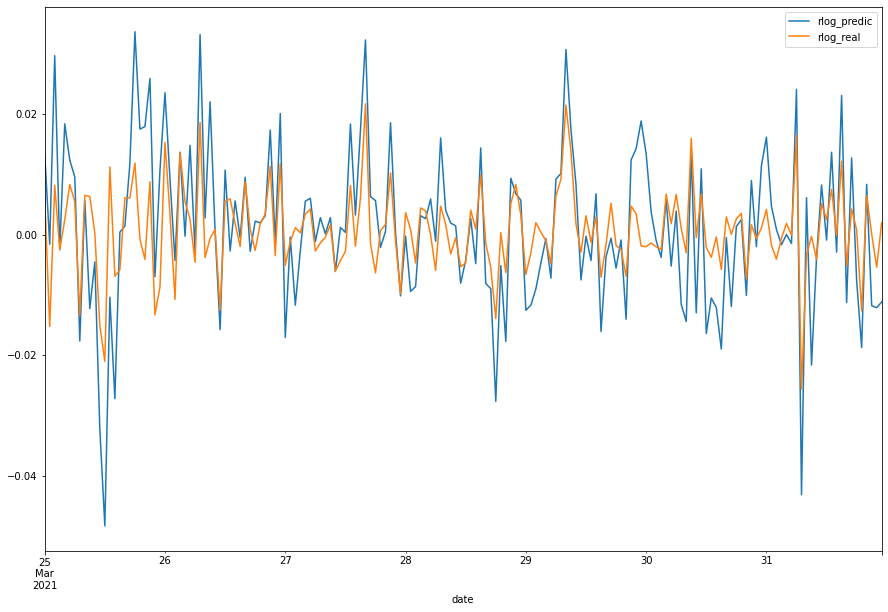

In [ ]:
predicciones_rendimiento_lr['25/03/2021':'31/03/2021'].plot(figsize=(15,10))

algunas predicciones parecieran ser bastante buenas y otras no tanto, si se observa como que se respeta la forma, pero no asi los signos, ya que se ven algunas grandes diferencias.
Por otro lado, tal vez la el signo de diferencia entre los rendimientos si pareciera ser mejor predicho, es decir, que el rendimiento actual es mayor o menor que el rendimiento anterior

##### **Precios obtenidos con rendimientos predichos**

In [ ]:
prediciones_precio=pd.DataFrame()
close_pred=pd.Series(map(lambda r_pred,p_ant:
                         p_ant*np.power(np.e,r_pred), 
                         predicciones_rendimiento_lr.loc[:,'rlog_predic'],
                         df.loc[cripto]['close'].shift(1)))  #El shift es porque hay que usar el rendimiento predicho con el precio de la sesion anterior para obtener el precio de cierre de la sesion actual

prediciones_precio['close']=df.loc[cripto]['close'][filtro_train_validation]
prediciones_precio['close_predic']=close_pred.values


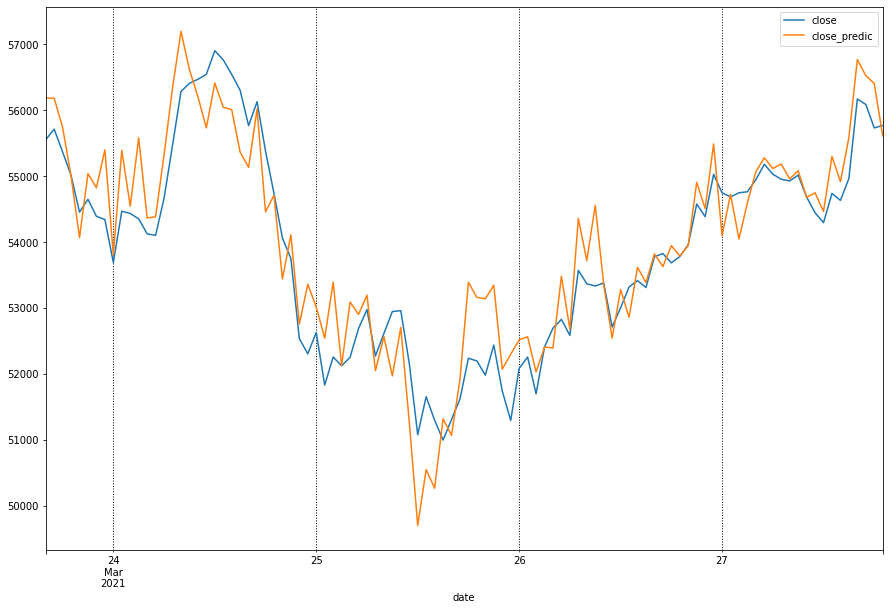

In [ ]:
prediciones_precio[-200:-100].plot(figsize=(15,10))
plt.grid(color='k', linestyle=':', linewidth=1,which= 'minor')
plt.legend()

##### **Predicciones Test**

In [ ]:
X_test=np.array(dic_cripto_test[cripto][0]) 
y_test=np.array(dic_cripto_test[cripto][1]) 

predicciones_rendimiento_lr_test=pd.DataFrame()
y_test_predict_lr=pipe_lr.predict(X_test)

predicciones_rendimiento_lr_test['rlog_real']=df.loc[cripto,'r_log_target']
predicciones_rendimiento_lr_test.loc[filtro_test,'r_log_predic_test']=y_test_predict_lr.reshape(-1)


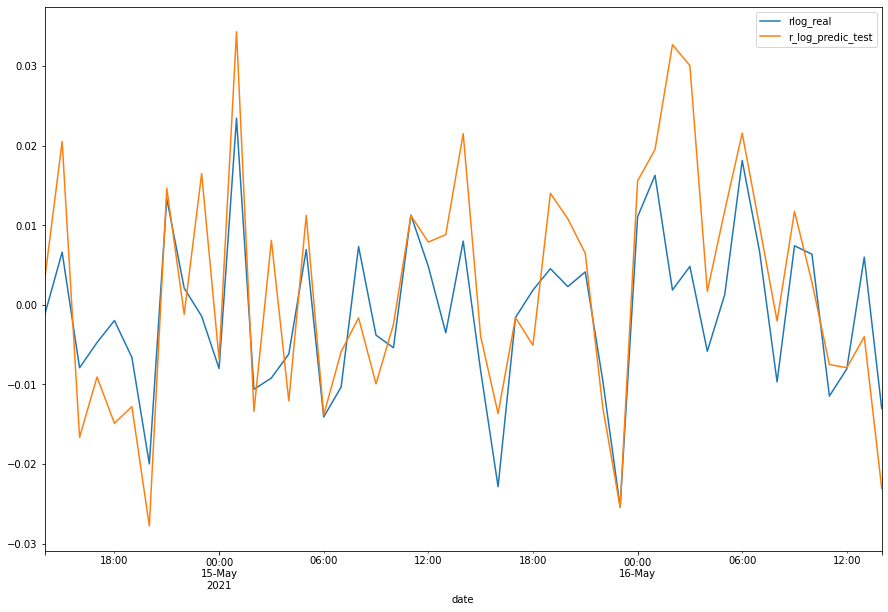

In [ ]:
predicciones_rendimiento_lr_test[-50:-1].plot(figsize=(15,10))

A simple vista se observa lo mismo que para el ser de train validation

In [ ]:
predicciones_rendimiento_lr_test['diferencia']=predicciones_rendimiento_lr_test.loc[filtro_test,'rlog_real']-predicciones_rendimiento_lr_test.loc[filtro_test,'r_log_predic_test']
predicciones_rendimiento_lr_test['diferencia'].describe()

count    1096.000000
mean       -0.000645
std         0.009320
min        -0.034707
25%        -0.005985
50%        -0.000577
75%         0.005057
max         0.043205
Name: diferencia, dtype: float64

In [ ]:
predicciones_rendimiento_lr_test.loc[filtro_test,'rlog_real'].describe()

count    1096.000000
mean       -0.000184
std         0.008084
min        -0.066617
25%        -0.003852
50%        -0.000168
75%         0.003859
max         0.036681
Name: rlog_real, dtype: float64

##### **Precios obtenidos con rendimientos predichos**

In [ ]:
predicciones_test=pd.DataFrame()

y_test_predict_lr=pipe_lr.predict(X_test)

close_pred=pd.Series(map(lambda x,y:
                         y*np.power(np.e,x), 
                         pd.Series(y_test_predict_lr.reshape(-1)),
                         df.loc[cripto]['close'][filtro_test].shift(1)))

predicciones_test['close']=df.loc[cripto,'close'][filtro_test]
predicciones_test.loc[:,'close_predic_test']=close_pred.values


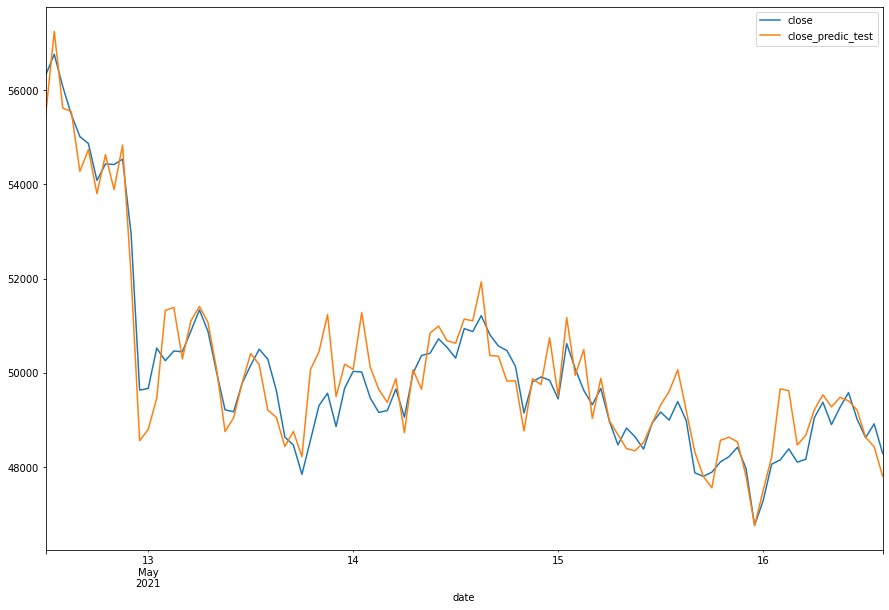

In [ ]:
predicciones_test[-100:-1]['close'].plot(figsize=(15,10))
predicciones_test[-100:-1]['close_predic_test'].plot(figsize=(15,10))
plt.legend()

In [ ]:
predicciones_test['diferencia']=predicciones_test['close']-predicciones_test['close_predic_test']
predicciones_test['diferencia'].describe()

count    1095.000000
mean      -37.030876
std       518.607085
min     -1974.464129
25%      -340.993285
50%       -34.632091
75%       290.365856
max      2349.721820
Name: diferencia, dtype: float64

Se observa que las predicciones de precio el 50% del tiempo estan entre **-341 y 289 USD de diferencia**

### Para todas las modenas

In [ ]:
resultado_coins={}                                                        #Diccionario para guardar los errores del modelo para cada crypto
predicciones_lr_rend={}                                               #Diccionario para guardar las predicciones del modelo para cada crypto
predicciones_lr_precio={} 
modelos_lineales={}

for cripto in coins:

  resultado_coins[cripto]=pd.DataFrame()                              #Dataframe para guardar errores
  predicciones_lr_precio[cripto]=pd.DataFrame()                         #Dataframe para guardar las predicciones
  predicciones_lr_rend[cripto]=pd.DataFrame()

  ##separación X e y
  X=np.array(dic_cripto_train_validation[cripto][0]) 
  y=np.array(dic_cripto_train_validation[cripto][1]) 

  X_test=np.array(dic_cripto_test[cripto][0]) 
  y_test=np.array(dic_cripto_test[cripto][1]) 



  ## Instancio el modelo:


  modelos_lineales[cripto]= Pipeline([
        (f'scale_{cripto}', StandardScaler(with_mean=True)),
        #('reduce_dims', PCA(n_components=10)),
        (f'transf_{cripto}',PolynomialFeatures(1)),
        (f'estimator_{cripto}', LinearRegression(fit_intercept=False))])


  ##Definicion del iterador
  cv=tscv.split(X)
    #cv=train_test_wf_exp(X,n_train=700,test_size=1)
    #cv=train_test_wf_roll(X,n_train=700,test_size=1)

  ##Resultado de errores de la validación cruzada
  cv_results = cross_validate(modelos_lineales[cripto], X, y, cv=cv,scoring={'RMSE':'neg_root_mean_squared_error',     #https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
                                                     'MSE':'neg_mean_squared_error',
                                                     'MAE':'neg_mean_absolute_error',
                                                     'MedAE':'neg_median_absolute_error'},
                             return_train_score=True,
                             #return_estimator=True
                              )

  ##Guardado de Errores
  resultado_coins[cripto]=pd.DataFrame(cv_results)


  ##Predicciones de Rendimientos
  modelos_lineales[cripto].fit(X,y)


  y_train_validation_lr_c=modelos_lineales[cripto].predict(X)
  y_test_predict_lr_c=modelos_lineales[cripto].predict(X_test)

  predicciones_lr_rend[cripto]['rlog_real']=df.loc[cripto,'r_log_target']
  predicciones_lr_rend[cripto].loc[filtro_train_validation,'r_log_predic_train_validation']=y_train_validation_lr_c.reshape(-1)
  predicciones_lr_rend[cripto].loc[filtro_test,'r_log_predic_test']=y_test_predict_lr_c.reshape(-1)



  ##Predicciones de Precio

  #p_close_pred=p_close_ant*e^(r_log)

  close_pred_train_validation=pd.Series(map(lambda x,y:
                          y*np.power(np.e,x), 
                          pd.Series( y_train_validation_lr_c.reshape(-1)),
                           df.loc[cripto][filtro_train_validation]['close'].shift(1)))
  

  close_pred_test=pd.Series(map(lambda x,y:
                          y*np.power(np.e,x), 
                          pd.Series( y_test_predict_lr_c.reshape(-1)),
                           df.loc[cripto][filtro_test]['close'].shift(1)))
  

  ##Guardado de Predicciones de precio
  predicciones_lr_precio[cripto]['close']=df.loc[cripto,'close']
  predicciones_lr_precio[cripto].loc[filtro_train_validation,'close_predic_train_validation']=close_pred_train_validation.values
  predicciones_lr_precio[cripto].loc[filtro_test,'close_predic_test']=close_pred_test.values


In [ ]:
errores_coins = pd.concat({k: v.describe().iloc[1:3,2:] for k, v in resultado_coins.items()})


errores_coins 

test_RMSE  train_RMSE  ...  test_MedAE  train_MedAE
NEOUSDT mean  -0.009770   -0.010553  ...   -0.006444    -0.005676
        std    0.005222    0.000479  ...    0.003726     0.000297
LTCUSDT mean  -0.007803   -0.009034  ...   -0.005239    -0.005164
        std    0.003036    0.000299  ...    0.001602     0.000205
ETHUSDT mean  -0.007005   -0.008099  ...   -0.004688    -0.004727
        std    0.002397    0.000164  ...    0.001759     0.000154
BTCUSDT mean  -0.005986   -0.006831  ...   -0.004308    -0.003742
        std    0.002062    0.000145  ...    0.001625     0.000191
BNBUSDT mean  -0.015123   -0.011666  ...   -0.009170    -0.005547
        std    0.017532    0.001179  ...    0.009572     0.000572

[10 rows x 8 columns]

Se observa que la modena con menores errores en sus prediciones es el **BTCUSDT**

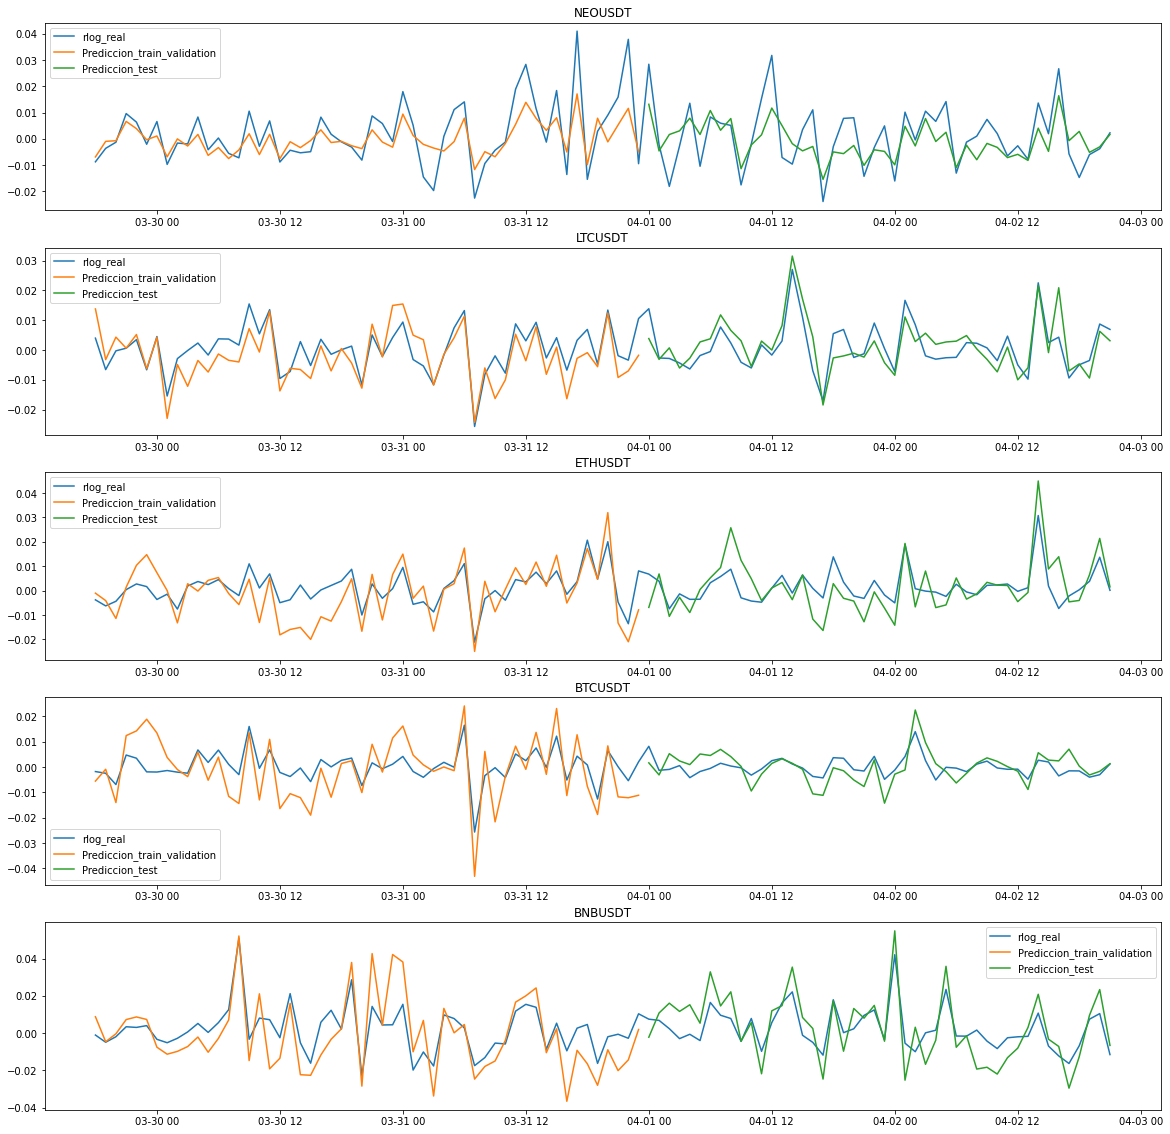

In [ ]:
##Grafico
fig, ax=plt.subplots(len(coins),1,figsize=(20,20))
i=0
for cripto in coins:
  ax[i].plot( predicciones_lr_rend[cripto][-1150:-1050]['rlog_real'],label='rlog_real')
  ax[i].plot( predicciones_lr_rend[cripto][-1150:-1050]['r_log_predic_train_validation'],label='Prediccion_train_validation')
  ax[i].plot( predicciones_lr_rend[cripto][-1150:-1050]['r_log_predic_test'],label='Prediccion_test')
  ax[i].set_title(cripto)
  ax[i].legend()
  i+=1

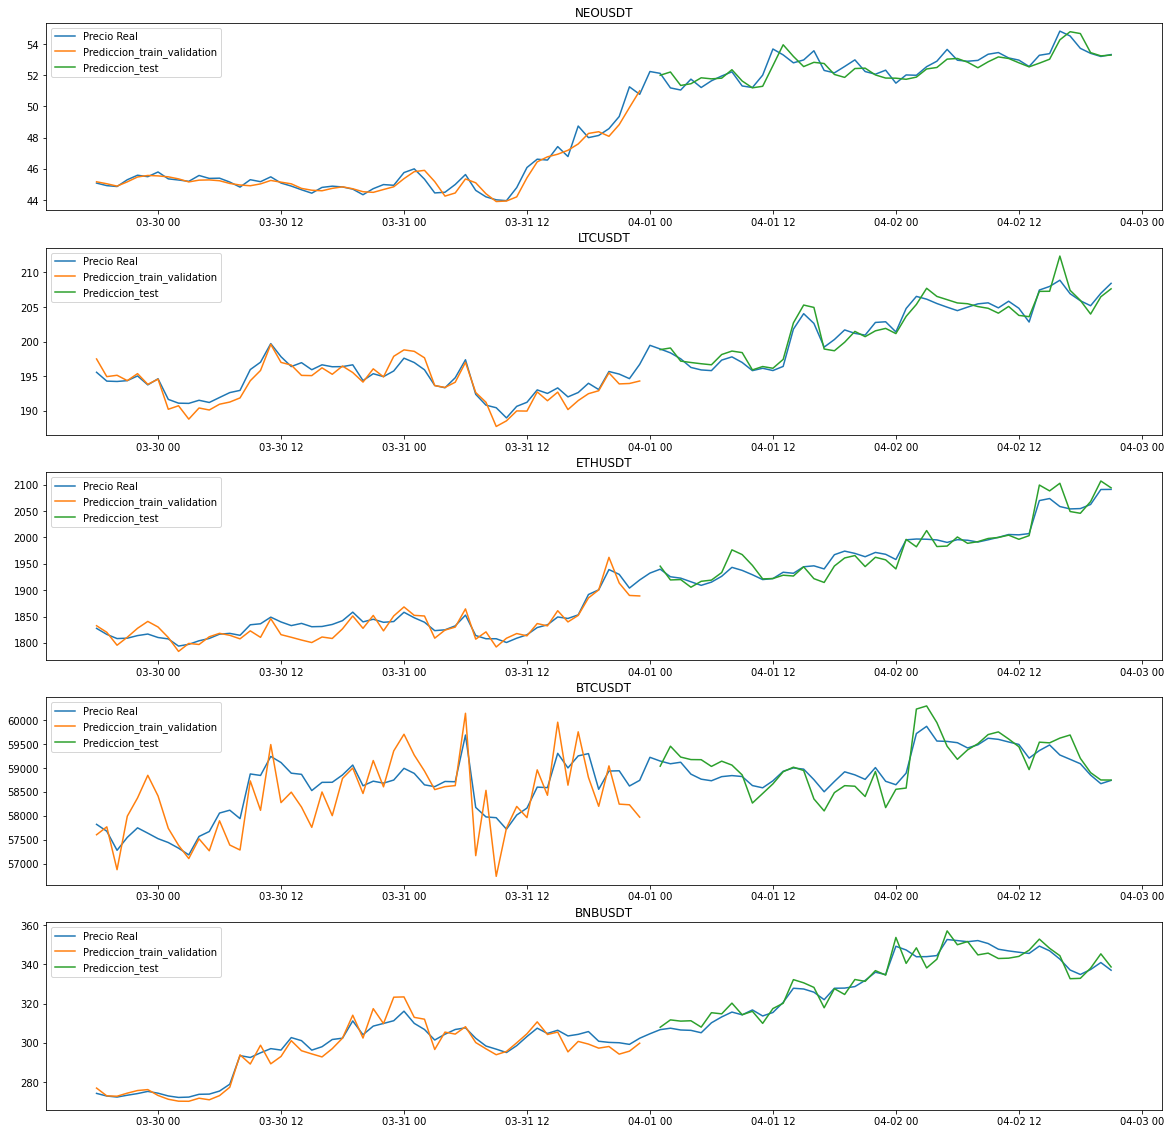

In [ ]:
##Grafico
fig, ax=plt.subplots(len(coins),1,figsize=(20,20))
i=0
for cripto in coins:
  ax[i].plot(predicciones_lr_precio[cripto][-1150:-1050]['close'],label='Precio Real')
  ax[i].plot(predicciones_lr_precio[cripto][-1150:-1050]['close_predic_train_validation'],label='Prediccion_train_validation')
  ax[i].plot(predicciones_lr_precio[cripto][-1150:-1050]['close_predic_test'],label='Prediccion_test')
  ax[i].set_title(cripto)
  ax[i].legend()
  i+=1

##**Parte II**


Creen un árbol de decisión de regresión (usando la función DecisionTreeRegressor de sklearn) para predecir el rendimiento específico del activo en la sesión siguiente, el árbol de decisiones debería ayudarnos a elegir la mejor combinación de indicadores y sus parámetros para maximizar el resultado esperado. Exploren diferentes valores para los parámetros del algoritmo (criterion, max_depth, min_samples_leaf).

Visualicen alguno de los árboles.


COLAB CON ARBOLES https://colab.research.google.com/drive/1jYH__H7qIK4gwC2yOpVj7mdp8mG0M8vg


### Arbol de regresión

In [ ]:
cripto='BTCUSDT'#Eleccion de Cripto a estudiar

X=np.array(dic_cripto_train_validation[cripto][0]) #Atributos
y=np.array(dic_cripto_train_validation[cripto][1]) #Objetivo
X_test=np.array(dic_cripto_test[cripto][0]) #Atributos test
y_test=np.array(dic_cripto_test[cripto][0]) #Objetivo test




#Grilla de hiperparametros:
param_grid_tree = {
    'estimator__criterion': ['mse',
                  #'friedman_mse',
                  'mae',
                  ],
    'estimator__max_depth': list(range(4,9)),        #Profundidad del arbol
    'estimator__min_samples_leaf':list(range(1,6))   #Minima cantidad de muestras por hoja
}




#Inicializar los modelos
reg_tree= DecisionTreeRegressor(random_state = 0)

pipe_tree = Pipeline([
        ('scale', StandardScaler(with_mean=True)),
        #('reduce_dims', PCA(n_components=10)),
        ('estimator', reg_tree)])




##Definicion del iterador
cv=tscv.split(X)
  #cv=train_test_wf_exp(X,n_train=700,test_size=1)
  #cv=train_test_wf_roll(X,n_train=700,test_size=1)




#GridSearchCV, entrena varios modelo en funcion de la grilla de parametros y busca el mejor
#GSCV_tree = GridSearchCV(reg_tree , param_grid_tree, scoring='neg_root_mean_squared_error', cv=cv)
GSCV_tree = GridSearchCV(pipe_tree , param_grid_tree, scoring='neg_root_mean_squared_error', cv=cv)



#### Implementación del modelo

In [ ]:
#Esta celda puede tardar más de 1 hora, para reducir el tiempo se pueden eliminar algunos parametros de la grilla, sobre todo los de criterio
GSCV_tree.fit(X, y);

In [ ]:
results = GSCV_tree.cv_results_
params = results['params']
mean = results['mean_test_score']
std = results['std_test_score']
rank = results['rank_test_score']
df_params=pd.DataFrame(params)
df_params['Error promedio']=mean
df_params['Desvio']=std
df_params['Ranking']=rank

#### Errores y resultados de la grilla de parametros

In [ ]:
df_params.sort_values(by='Ranking')

,estimator__criterion,estimator__max_depth,estimator__min_samples_leaf,Error promedio,Desvio,Ranking
4,mse,4,5,-0.009110,0.002323,1
3,mse,4,4,-0.009179,0.002328,2
34,mae,5,5,-0.009347,0.003217,3
29,mae,4,5,-0.009359,0.003124,4
33,mae,5,4,-0.009366,0.003104,5
28,mae,4,4,-0.009373,0.003110,6
31,mae,5,2,-0.009405,0.003474,7
9,mse,5,5,-0.009422,0.002541,8
32,mae,5,3,-0.009430,0.003433,9
27,mae,4,3,-0.009497,0.003444,10


In [ ]:
best_tree=GSCV_tree.best_estimator_
best_tree

Pipeline(steps=[('scale', StandardScaler()),
                ('estimator',
                 DecisionTreeRegressor(max_depth=4, min_samples_leaf=5,
                                       random_state=0))])

#### Impresión del Árbol

In [ ]:
best_tree

Pipeline(steps=[('scale', StandardScaler()),
                ('estimator',
                 DecisionTreeRegressor(max_depth=4, min_samples_leaf=5,
                                       random_state=0))])

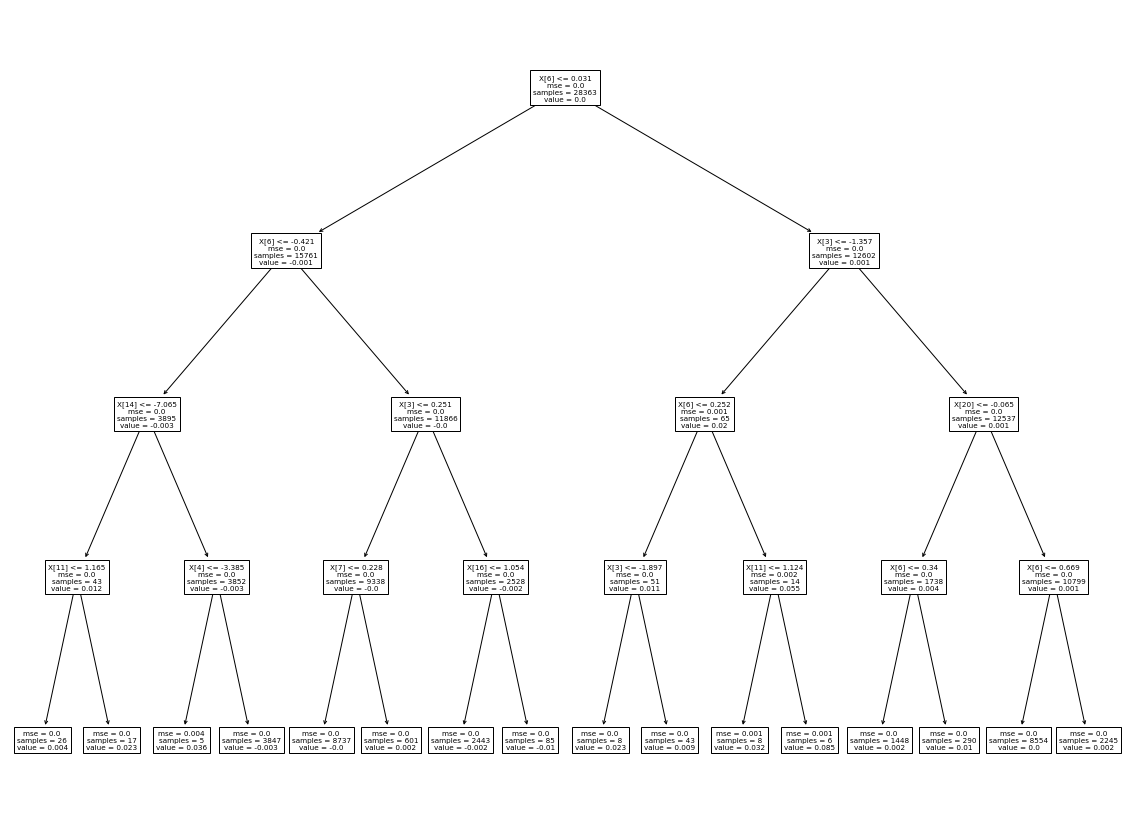

In [ ]:

fig,ax=plt.subplots(1,1,figsize=(20,15))
plot_tree(best_tree['estimator'] ,ax=ax);


#### Predicciones

In [ ]:
predicciones_rendimiento_tree=pd.DataFrame()
y_train_validation_pred_tree=best_tree.predict(X)
predicciones_rendimiento_tree.loc[:,'rlog_predic']=y_train_validation_pred_tree.reshape(-1)
predicciones_rendimiento_tree.loc[:,'rlog_real']=y


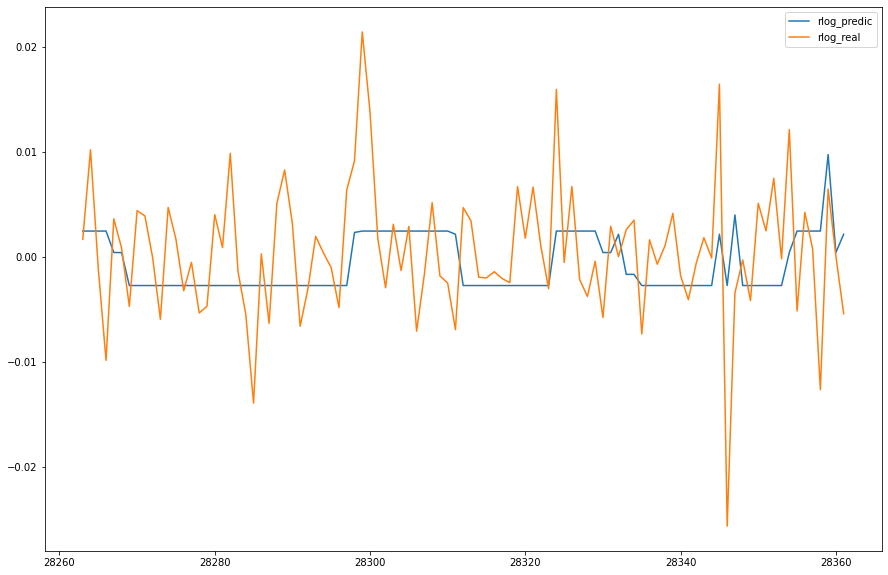

In [ ]:
predicciones_rendimiento_tree[-100:-1].plot(figsize=(15,10))

In [ ]:
##Predicciones de Precio

#p_close_pred=p_close_ant*e^(r_log)
close_pred_train_validation=pd.Series(map(lambda x,y:
                         y*np.power(np.e,x), 
                         pd.Series(y_train_validation_pred_tree.reshape(-1)),
                         df.loc[cripto][filtro_train_validation]['close'].shift(1)))

y_test_pred_tree=best_tree.predict(X_test)
close_pred_test=pd.Series(map(lambda x,y:
                          y*np.power(np.e,x), 
                          pd.Series(y_test_pred_tree.reshape(-1)),
                           df.loc[cripto][filtro_test]['close'].shift(1)))
  
##Guardado de Predicciones 
predicciones_tree=pd.DataFrame() 
predicciones_tree['close']=df.loc[cripto,'close']
predicciones_tree.loc[filtro_train_validation,'close_predic_train_validation']=close_pred_train_validation.values
predicciones_tree.loc[filtro_test,'close_predic_test']=close_pred_test.values

#### Impresión de predicciones de Precio

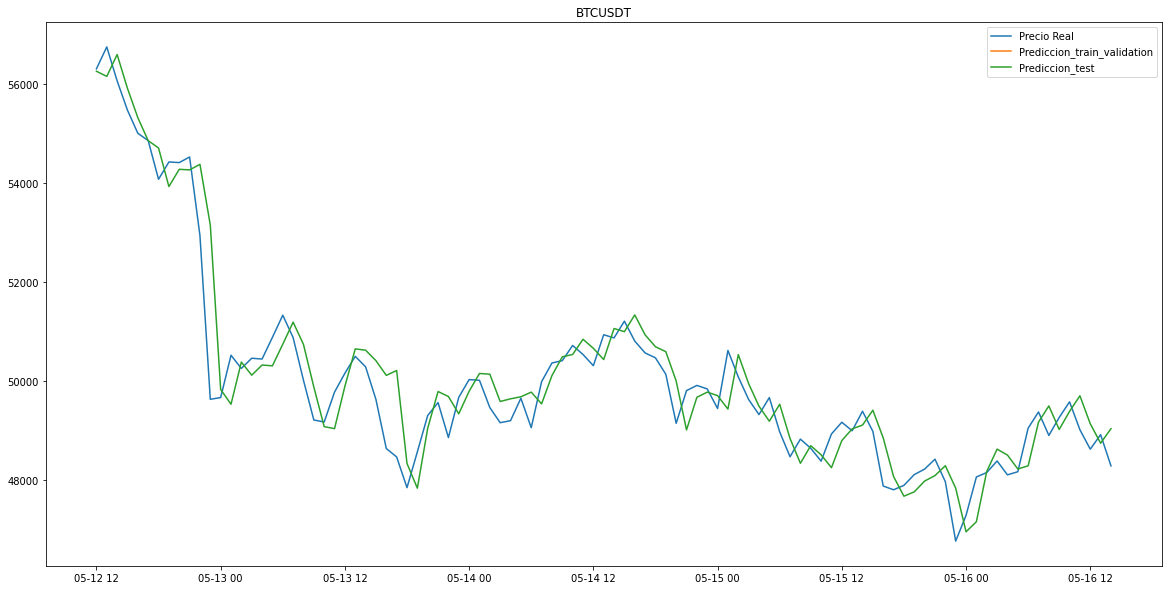

In [ ]:
fig, ax=plt.subplots(1,1,figsize=(20,10))
ax.plot(predicciones_tree[-100:-1]['close'],label='Precio Real')
ax.plot(predicciones_tree[-100:-1]['close_predic_train_validation'],label='Prediccion_train_validation')
ax.plot(predicciones_tree[-100:-1]['close_predic_test'],label='Prediccion_test')
ax.set_title(cripto)
ax.legend()

## Comparación Regresión Lineal y árbol de regresión


In [ ]:
cripto='BTCUSDT'

**Errores**

Se observa que los error **RMSE** sobre el conjunto de Test es menor el del árbol que el de la regresión líneal

In [ ]:
y_test=np.array(dic_cripto_test[cripto][1])

error_rl=np.sqrt(mean_squared_error(y_test, y_test_predict_lr))
error_tree=np.sqrt(mean_squared_error(y_test,y_test_pred_tree))
print('Error regresión lineal:',error_rl,'Error árbol:',error_tree,'Relación:',error_rl/error_tree)

Error regresión lineal: 0.009337579711207931 Error árbol: 0.008166641878242387 Relación: 1.1433805780176505


In [ ]:
#Prueba con rendimientos todos nulos
rendim_nulo=np.zeros(len(y_test))
error_rendim_nulo=np.sqrt(mean_squared_error(y_test,rendim_nulo))
error_rendim_nulo

0.008082481084695366

El error al considerar rendimientos nulos es apenas menor a los errores de los modelos, siendo el modelo de regresión lineal el que da peores resultados, cambiando los atributos X se puedo obtener menores errores en la regresión lineal

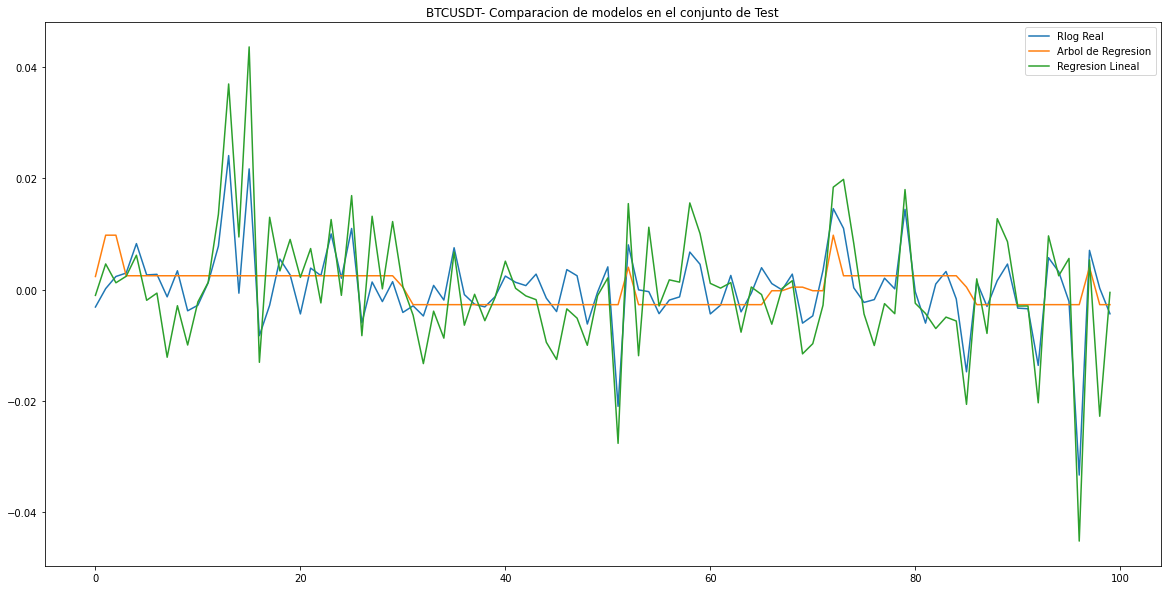

In [ ]:
fig, ax=plt.subplots(1,1,figsize=(20,10))
ax.plot(y_test[-400:-300],label='Rlog Real')

ax.plot(y_test_pred_tree[-400:-300],label='Arbol de Regresion')
ax.plot(y_test_predict_lr[-400:-300]*.9,label='Regresion Lineal')
ax.set_title(cripto+'- Comparacion de modelos en el conjunto de Test')
ax.legend()

Observando un fragmento de los rendimientos predichos, se ve que los rendimientos predichos por el árbol son más acotados y cercanos a cero, por otro lado los predichos por la regresión son más dinamicos y parecieran copiar más la forma, pero al parecer son más exagerados (se distancian más que los producidos por el árbol. Igual depende mucho de las columnas que se elijan para formar las X, alguna combinacion permitio bajar más el error de la regresión lineal, pero ya no seguia tanto la forma

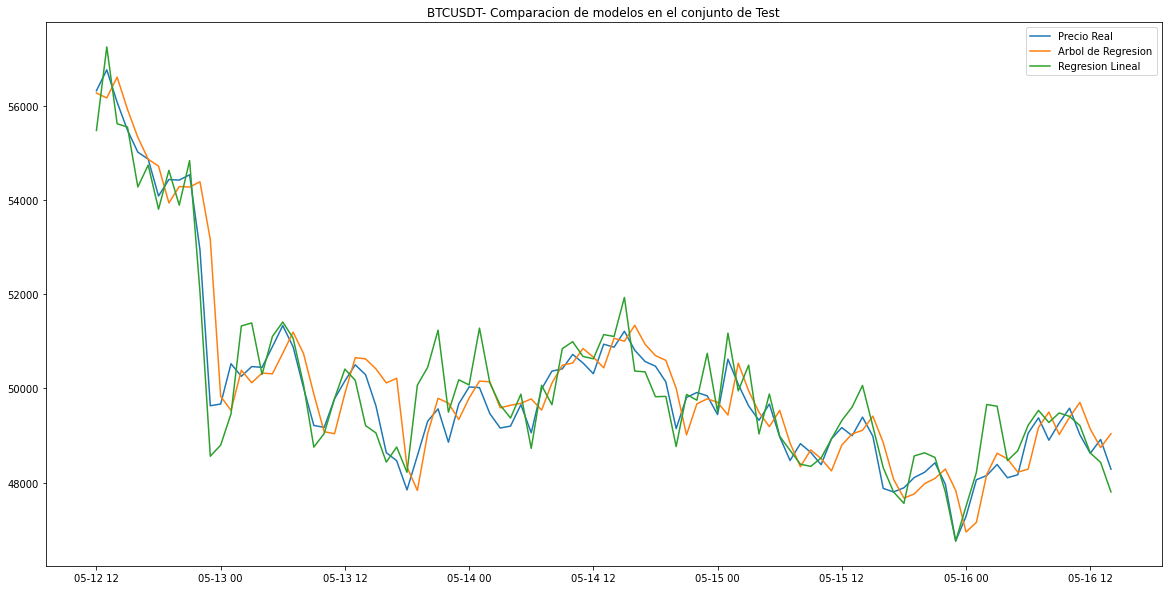

In [ ]:
fig, ax=plt.subplots(1,1,figsize=(20,10))
ax.plot(predicciones_tree[-100:-1]['close'],label='Precio Real')

ax.plot(predicciones_tree[-100:-1]['close_predic_test'],label='Arbol de Regresion')
ax.plot(predicciones_lr_precio[cripto][-100:-1]['close_predic_test'],label='Regresion Lineal')
ax.set_title(cripto+'- Comparacion de modelos en el conjunto de Test')
ax.legend()


In [ ]:
precio_test=predicciones_tree['close']['2021-04-01 01:00:00':]


error_rl=np.sqrt(mean_squared_error(precio_test, predicciones_lr_precio[cripto]['close_predic_test']['2021-04-01 01:00:00':]))

error_tree=np.sqrt(mean_squared_error(precio_test,predicciones_tree['close_predic_test']['2021-04-01 01:00:00':]))
print('Error regresión lineal:',error_rl,'Error árbol:',error_tree,'Relación:',error_rl/error_tree)

Error regresión lineal: 519.6912307412961 Error árbol: 446.1614975654655 Relación: 1.1648051962732207


In [ ]:
precio_rendim_nulo=predicciones_tree['close'].shift(1)['2021-04-01 01:00:00':]
error_rendim_nulo=np.sqrt(mean_squared_error(precio_test,precio_rendim_nulo))
error_rendim_nulo

441.9533182421679

**Conclusión:** estimar el mismo precio anterior es mejor que los modelos obtenidos



## **Parte III - Opcional**


 
- Repitan algunos de los experimentos utilizando diferentes temporalidades (1 hora, 1 día, 1 semana). 
- Apliquen árboles de clasificación para decidir si un activo mantendrá su precio, subirá o disminuirá. Observación: Pueden utlizar las mismas variables predictoras que en el caso de árboles de regresión, solo deben modificar la variable target. 


### **Diferentes temporalidades.**



Va a ser necesario recalcular los indicadores para las difrentes temporalidades

#### **Cambiar Temporalidad de los datos**

In [ ]:
# Elección de Temporalidad
temp='5h'

In [ ]:
df_t=df_imp.loc[:,'open':'volume'].copy()

# Diccionario con las funciones para agrupar en las nuevas ohlcv
ohlc_dict = {                                                                                                             
'open':'first',                                                                                                    
'high':'max',                                                                                                       
'low':'min',                                                                                                        
'close': 'last',                                                                                                    
'volume': 'sum'
}

In [ ]:
df_temp=pd.DataFrame()
for cripto in coins:
  df_Aux=pd.DataFrame()
  df_Aux=df_t.loc[cripto].resample(temp, closed='left', label='left').apply(ohlc_dict)
  df_Aux['cripto_activo']=cripto
  df_temp=pd.concat([df_temp,df_Aux])           
df_temp=df_temp.reset_index().set_index(['cripto_activo','date'])

#### **Recalculo de Features**

Medias Moviles

In [ ]:
periodos=[3,15,60]
for n in periodos:
  for cripto in coins:
    df_temp.loc[cripto,f'media_movil_{n}_periodos']=df_temp.loc[cripto,'close'].shift(1).rolling(n).mean().values

In [ ]:
for cripto in coins:
  # Rendimientos
  df_temp.loc[cripto,'rendimiento_simple']=df_temp.loc[cripto,'close'].shift(1).pct_change().values
  df_temp.loc[cripto,'rendimiento_log']=np.log(df_temp.loc[cripto,'close']/df_temp.loc[cripto,'close'].shift(1)).shift(1).values

  # RSI
  df_temp.loc[cripto,'RSI_14'] = talib.RSI(df_temp.loc[cripto]['close'].shift(1).values, timeperiod=14)
  df_temp.loc[cripto,'RSI_6'] = talib.RSI(df_temp.loc[cripto]['close'].shift(1).values, timeperiod=6)
  df_temp.loc[cripto,'RSI_100'] = talib.RSI(df_temp.loc[cripto]['close'].shift(1).values, timeperiod=100)

  # MACD
  macd, signal, hist = talib.MACD(df_temp.loc[cripto]['close'].shift(1).values, fastperiod=12, slowperiod=26, signalperiod=9)
  df_temp.loc[cripto,'MACD'] = macd
  df_temp.loc[cripto,'signal'] = signal
  df_temp.loc[cripto,'hist'] = hist

  # ADX ATR
  df_temp.loc[cripto,'ADX']=ADX(df_temp.loc[cripto], period=14)['ADX'].shift(1).values
  df_temp.loc[cripto,'ATR']=ADX(df_temp.loc[cripto], period=14)['ATR'].shift(1).values

  # MFI
  df_temp.loc[cripto,'MFI'] = talib.MFI(df_temp.loc[cripto,'high'].shift(1).values, 
                                     df_temp.loc[cripto,'low'].shift(1).values, 
                                     df_temp.loc[cripto,'close'].shift(1).values , 
                                     df_temp.loc[cripto,'volume'].shift(1).values, 
                                     timeperiod=14)
  # OBV
  df_temp.loc[cripto,'OBV'] = talib.OBV( df_temp.loc[cripto,'close'].shift(1).values , 
                                     df_temp.loc[cripto,'volume'].shift(1).values)

  #Volatilidad
  df_temp.loc[cripto,'Volatilidad_50_periodos']=df_temp.loc[cripto,'rendimiento_log'].rolling(50).std().shift(1).values

  #STD_U STD_D
  df_temp.loc[cripto,'Std_U'] =(df_temp.loc[cripto,'high']-df_temp.loc[cripto,'open']).shift(1).values
  df_temp.loc[cripto,'Std_D'] = (df_temp.loc[cripto,'open']-df_temp.loc[cripto,'low']).shift(1).values

  #Correlacion
  df_temp.loc[cripto,'Corr_3_periodos'] = df_temp.loc[cripto,'close'].shift(1).rolling(window=10).corr(df_temp['media_movil_3_periodos'].shift(1))

  #OD y OL
  df_temp.loc[cripto,'OD'] = df_temp.loc[cripto]['open'].values-df_temp.loc[cripto]['open'].shift(1).values
  df_temp.loc[cripto,'OL'] = df_temp.loc[cripto]['open'].values-df_temp.loc[cripto]['close'].shift(1).values

  #Close y volumen before
  df_temp.loc[cripto,'close_before']=df_temp.loc[cripto,'close'].shift(1).values
  df_temp.loc[cripto,'volume_before']=df_temp.loc[cripto,'volume'].shift(1).values

  #Columna objetivo y
  df_temp.loc[cripto,'r_log_target']=np.log(df_temp.loc[cripto,'close']/df_temp.loc[cripto,'close'].shift(1)).values

**Cambio de Nombre de Columnas**




In [ ]:
nvo_nombres={'rendimiento_simple':'r_sim',
             'rendimiento_log':'r_log',
             'media_movil_3_periodos':'mean_m3',
             'media_movil_15_periodos':'mean_m15',
             'media_movil_60_periodos':'mean_m60',
             'Volatilidad_50_periodos':'vol_50',
             'Corr_3_periodos':'corr_3'
             }
             
df_temp=df_temp.rename(columns=nvo_nombres) 

**Variables Categoricas nuevas**

In [ ]:
df_temp['MACDSIGgtMACD'] = np.where(df_temp['signal'] > df_temp['MACD'], 1, -1)
df_temp['ClgtS15'] = np.where(df_temp['close'].shift(1) > df_temp['mean_m15'], 1, -1)
df_temp['S15gtS60'] = np.where(df_temp['mean_m15'] > df_temp['mean_m60'], 1, -1)
df_temp['Cat_MFI']=np.where(df_temp['MFI'] > 80, -1, np.where(df_temp['MFI'] < 20, 1,0))
df_temp['Cat_RSI100']=np.where(df_temp['RSI_100'] > 80, -1, np.where(df_temp['RSI_100'] < 20, 1,0))
df_temp['Cat_RSI6']=np.where(df_temp['RSI_6'] > 80, -1, np.where(df_temp['RSI_6'] < 20, 1,0))
df_temp['Cat_RSI14']=np.where(df_temp['RSI_14'] > 80, -1, np.where(df_temp['RSI_14'] < 20, 1,0))

**Limpieza de NAN**

In [ ]:
df_temp.dropna(inplace=True) 

#### **Definición de columnas de X**

In [ ]:
x_columns=[	
           #'r_log',	
           'mean_m3',	'mean_m15'	,'mean_m60',	
           'RSI_6',	'RSI_14'	,'RSI_100',
           'hist'	,'MACD',	'signal',
           'ADX'	,'ATR',	'vol_50',	
           'Std_U',	'Std_D'	,	'OD'	,'OL',	'corr_3','OBV','MFI',
           'MACDSIGgtMACD','ClgtS15','Cat_MFI','Cat_RSI6','Cat_RSI14','Cat_RSI100','S15gtS60',
           #'close_before',#'volume_before',
           ]


#### **Regresion Lineal**

In [ ]:
resultado_coins_temp={}                                                        #Diccionario para guardar los errores del modelo para cada crypto
predicciones_lr_rend_temp={}                                               #Diccionario para guardar las predicciones del modelo para cada crypto
predicciones_lr_precio_temp={} 
modelos_lineales_temp={}



for cripto in coins:

  resultado_coins_temp[cripto]=pd.DataFrame()                              #Dataframe para guardar errores
  predicciones_lr_precio_temp[cripto]=pd.DataFrame()                         #Dataframe para guardar las predicciones
  predicciones_lr_rend_temp[cripto]=pd.DataFrame()




  ##separación X e y

  y_test=df_temp.loc[cripto,y_columns][filtro_test] 
  X_test=df_temp.loc[cripto,x_columns][filtro_test] 


  y=df_temp.loc[cripto,y_columns][filtro_train_validation] 
  X=df_temp.loc[cripto,x_columns][filtro_train_validation] 




  ## Instancia del modelo:

  modelos_lineales_temp[cripto]= Pipeline([
        (f'scale_{cripto}', StandardScaler(with_mean=True)),
        #('reduce_dims', PCA(n_components=10)),
        (f'transf_{cripto}',PolynomialFeatures(1)),
        (f'estimator_{cripto}', LinearRegression(fit_intercept=False))])




  ## Definicion del iterador
  cv=tscv.split(X)
    #cv=train_test_wf_exp(X,n_train=700,test_size=1)
    #cv=train_test_wf_roll(X,n_train=700,test_size=1)




  ## Resultado de errores de la validación cruzada
  cv_results_temp = cross_validate(modelos_lineales_temp[cripto], X, y, cv=cv,scoring={'RMSE':'neg_root_mean_squared_error',     #https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
                                                     'MSE':'neg_mean_squared_error',
                                                     'MAE':'neg_mean_absolute_error',
                                                     'MedAE':'neg_median_absolute_error'},
                             return_train_score=True,
                             #return_estimator=True
                              )



  ## Guardado de Errores
  resultado_coins_temp[cripto]=pd.DataFrame(cv_results_temp)




  ## Predicciones de Rendimientos
  modelos_lineales_temp[cripto].fit(X,y)


  y_train_validation_lr_c_temp=modelos_lineales_temp[cripto].predict(X)
  y_test_predict_lr_c_temp=modelos_lineales_temp[cripto].predict(X_test)

  predicciones_lr_rend_temp[cripto]['rlog_real']=df_temp.loc[cripto,'r_log_target']
  predicciones_lr_rend_temp[cripto].loc[filtro_train_validation,'r_log_predic_train_validation']=y_train_validation_lr_c_temp.reshape(-1)
  predicciones_lr_rend_temp[cripto].loc[filtro_test,'r_log_predic_test']=y_test_predict_lr_c_temp.reshape(-1)





  ## Predicciones de Precio

  #p_close_pred=p_close_ant*e^(r_log)

  close_pred_train_validation_temp=pd.Series(map(lambda x,y:
                          y*np.power(np.e,x), 
                          pd.Series( y_train_validation_lr_c_temp.reshape(-1)),
                           df_temp.loc[cripto][filtro_train_validation]['close'].shift(1)))
  

  close_pred_test_temp=pd.Series(map(lambda x,y:
                          y*np.power(np.e,x), 
                          pd.Series( y_test_predict_lr_c_temp.reshape(-1)),
                           df_temp.loc[cripto][filtro_test]['close'].shift(1)))
  


  ## Guardado de Predicciones de precio
  predicciones_lr_precio_temp[cripto]['close']=df_temp.loc[cripto,'close']
  predicciones_lr_precio_temp[cripto].loc[filtro_train_validation,'close_predic_train_validation']=close_pred_train_validation_temp.values
  predicciones_lr_precio_temp[cripto].loc[filtro_test,'close_predic_test']=close_pred_test_temp.values


In [ ]:
errores_coins_temp = pd.concat({k: v.describe().iloc[1:3,2:] for k, v in resultado_coins_temp.items()})
errores_coins_temp

test_RMSE  train_RMSE  ...  test_MedAE  train_MedAE
NEOUSDT mean  -0.029517   -0.026000  ...   -0.016353    -0.011652
        std    0.009161    0.001185  ...    0.005525     0.000660
LTCUSDT mean  -0.025519   -0.022879  ...   -0.014379    -0.008990
        std    0.009110    0.001459  ...    0.005747     0.000822
ETHUSDT mean  -0.022546   -0.022104  ...   -0.011924    -0.008476
        std    0.008142    0.000993  ...    0.005520     0.000690
BTCUSDT mean  -0.018519   -0.017954  ...   -0.010168    -0.005828
        std    0.007830    0.000821  ...    0.005177     0.000490
BNBUSDT mean  -0.028729   -0.023107  ...   -0.014915    -0.009177
        std    0.018862    0.001574  ...    0.007868     0.000572

[10 rows x 8 columns]

Los errores son superiores a las sesiones de 1 hora

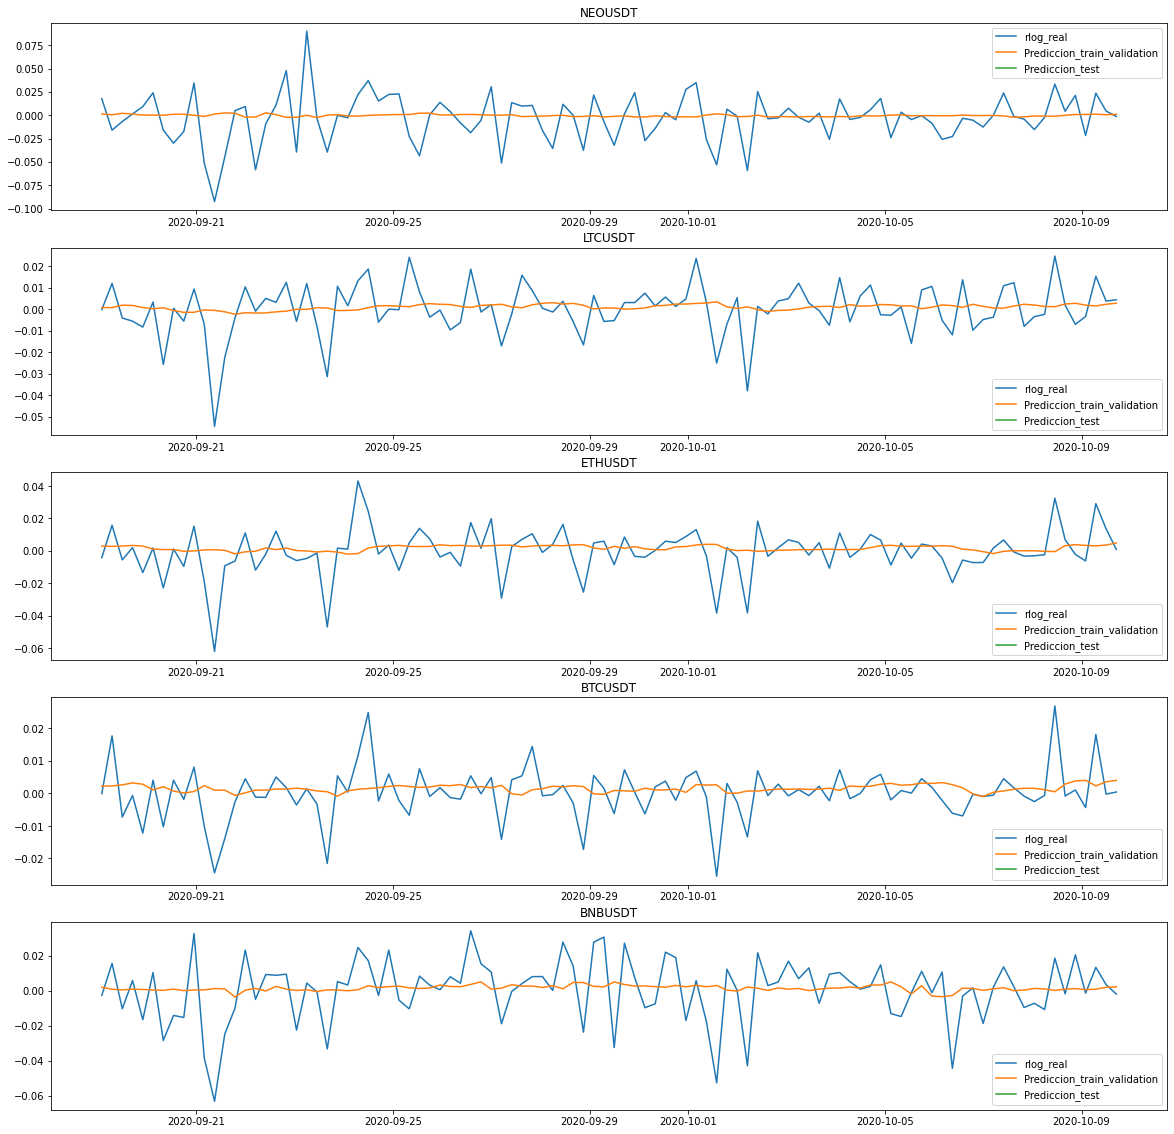

In [ ]:
##Grafico
fig, ax=plt.subplots(len(coins),1,figsize=(20,20))
i=0
for cripto in coins:
  ax[i].plot( predicciones_lr_rend_temp[cripto][-1150:-1050]['rlog_real'],label='rlog_real')
  ax[i].plot( predicciones_lr_rend_temp[cripto][-1150:-1050]['r_log_predic_train_validation'],label='Prediccion_train_validation')
  ax[i].plot( predicciones_lr_rend_temp[cripto][-1150:-1050]['r_log_predic_test'],label='Prediccion_test')
  ax[i].set_title(cripto)
  ax[i].legend()
  i+=1

No se observa el mismo seguimiento de forma que con las sesiones de 1 hora, se ve una estimación mucho más suave

### **Árbol de Clasificación**

#### **Creación de objetivo categorico**

In [ ]:
df_clasf=df.copy()

for cripto in coins: 
  #Columna objetivo y, seria rendimiento logaritmico de la sesion actual  
  df_clasf.loc[cripto,'r_log_clasif']=np.where(df_clasf.loc[cripto,'r_log_target'] >0, 1, np.where(df_clasf.loc[cripto,'r_log_target'] < 0, -1,0))


  #el r log que traemos es de la ultima sesion y la penultima (pasado) y nuestro objetivo  es el rendimiento de la sesion actual o "futura"


In [ ]:
df_clasf.head(3)

open    close  ...  Cat_RSI14  r_log_clasif
cripto_activo date                                   ...                         
BNBUSDT       2018-01-05 05:00:00   9.2249   9.4283  ...          0           1.0
              2018-01-05 06:00:00   9.4000  10.0798  ...          0           1.0
              2018-01-05 07:00:00  10.0798  10.1300  ...          0           1.0

[3 rows x 37 columns]

#### **Separar en X e Y**

In [ ]:
y_columns_clas=['r_log_clasif']

#Columnas de Atributos a usar

#x_columns=list(df.columns)
#col_del=['r_log_target','close','low','high']         #Columnas a dejar afuera. Dejamos afuera la columna con los rendimientos objetivos, dejamos afuera la columna close, low y high porque seria información del "Futuro"
#x_columns=[x for x in x_columns if x not in col_del]  #Quedan columnas con atributos

x_columns_clas=[		
           'r_log',	
           'mean_m3',	'mean_m15'	,'mean_m60',	
           'RSI_6',	'RSI_14'	,'RSI_100',
           'hist'	,'MACD',	'signal',
           'ADX'	,'ATR',	'vol_50',	
           'Std_U',	'Std_D'	,	'OD'	,'OL',	'corr_3','OBV','MFI',
           'MACDSIGgtMACD','ClgtS15','Cat_MFI','Cat_RSI6','Cat_RSI14','Cat_RSI100','S15gtS60',
           'close_before','volume_before',
           ]


#### **Separar Subconjunto de Entrenamiento, Validacion del subconjunto de evaluacion**

In [ ]:
#Filtros para separar train_ validation de Test

filtro_train_validation=slice('03-2021')
filtro_test=slice('04-2021','05-2021')

In [ ]:
X_train=df_clasf.loc[cripto,x_columns_clas][filtro_train_validation]
y_train=df_clasf.loc[cripto,y_columns_clas][filtro_train_validation]
X_test=df_clasf.loc[cripto,x_columns_clas][filtro_test]
y_test=df_clasf.loc[cripto,y_columns_clas][filtro_test]

#### **Implementación de modelo**

In [ ]:
#Grilla de hiperparametros:
param_grid_tree = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': list(range(3,20)),
    'min_samples_leaf':list(range(1,6)),
}

#Inicializar los modelos
clf_tree = DecisionTreeClassifier(random_state = 0)

cv=tscv.split(X_train)
  #cv=train_test_wf_exp(X,n_train=700,test_size=1)
  #cv=train_test_wf_roll(X,n_train=700,test_size=1)


#GridSearchCV, hace el K_fold al otorgar un valor entero a CV, por defecto lo hace estratificado
cv_clas = GridSearchCV(clf_tree, param_grid_tree, scoring='accuracy', cv=cv)

cv_clas.fit(X_train, y_train);

y_train_pred = cv_clas.predict(X_train)
y_test_pred = cv_clas.predict(X_test)

#### **Resultado**

In [ ]:
results = cv_clas.cv_results_
params = results['params']
mean = results['mean_test_score']
std = results['std_test_score']
rank = results['rank_test_score']
df_result=pd.DataFrame(params)
df_result['Accuracy promedio']=mean
df_result['Desvio']=std
df_result['Ranking']=rank

In [ ]:
df_result.sort_values(by='Ranking')

,criterion,max_depth,min_samples_leaf,splitter,Accuracy promedio,Desvio,Ranking
155,gini,18,3,random,0.579,0.056471,1
145,gini,17,3,random,0.576,0.052764,2
319,entropy,17,5,random,0.569,0.038328,3
206,entropy,6,4,best,0.568,0.041183,4
200,entropy,6,1,best,0.564,0.044542,5
...,...,...,...,...,...,...,...
148,gini,17,5,best,0.501,0.035057,336
292,entropy,15,2,best,0.500,0.044721,337
76,gini,10,4,best,0.499,0.035903,338
290,entropy,15,1,best,0.499,0.029816,338


In [ ]:
tree_clas=cv_clas.best_estimator_

#### **Gráfico de árbol**

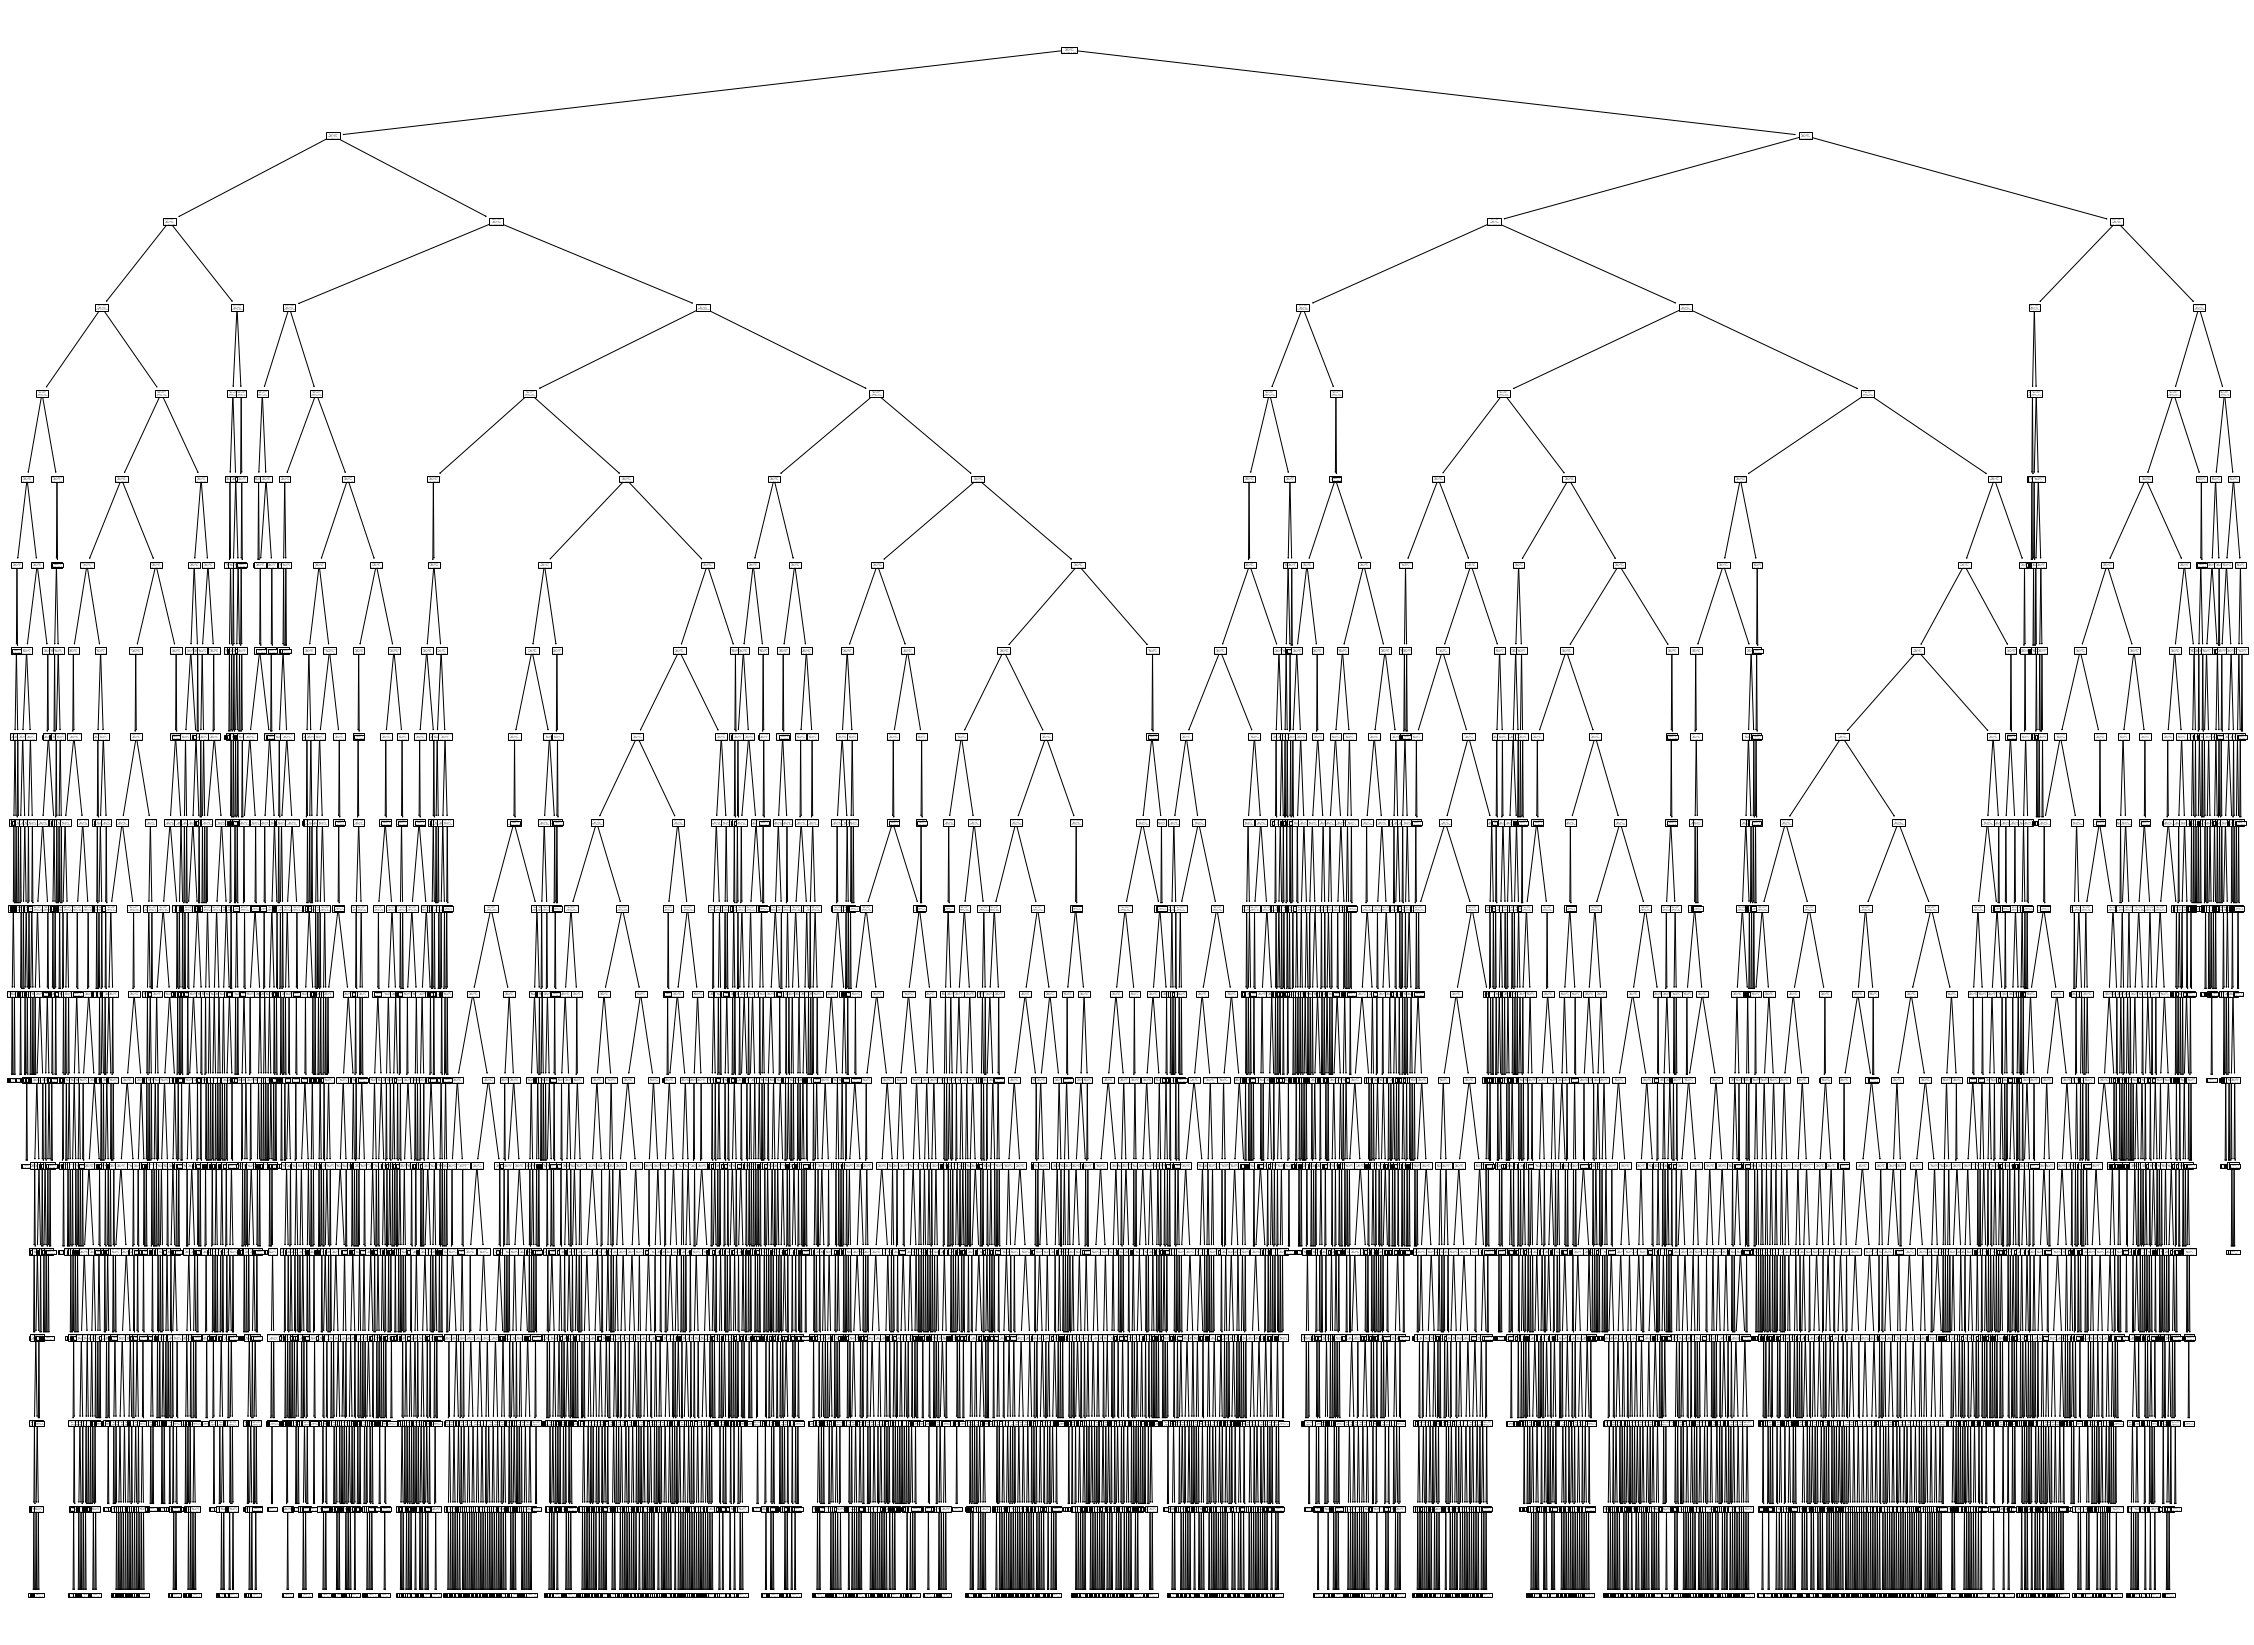

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(40,30))
plot_tree(tree_clas,ax=ax);

#### **Accuracy**

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_test_pred)

0.5209854014598541

Se obtiene un accuracy de 52%, apenas superior a lanzar una moneda

#### **Prediccion de Signo de rendimiento con los resultados de la Regresión Lineal**

In [ ]:
y_test_pred_lr_clas=np.where(predicciones_lr_rend[cripto].loc[filtro_test,'r_log_predic_test']>0.005, 1, np.where(predicciones_lr_rend[cripto].loc[filtro_test,'r_log_predic_test'] <= 0.005, -1,0))

##### **Accuracy**

In [ ]:
accuracy_score(y_test, y_test_pred_lr_clas)

0.7773722627737226

Es un resultado que coindice con lo que se ve en los graficos que comparan la regresión lineal con los valores reales, por otro lado es un resultado prometedor